# Explicacion como contexto

predecir las futuras bicicletas compartidas

Contenido
Los datos se adquieren de 3 fuentes:

cycling.data.tfl 'Contiene datos del sistema operativo © Crown copyright y derechos de base de datos 2016' y Geomni UK Map data © y derechos de base de datos [2019] 'Desarrollado por TfL Open Data'
freemeteo.com - datos del tiempo

https://www.gov.uk/bank-holidays
Del 1/1/2015 al 31/12/2016

Los datos del conjunto de datos de ciclismo están agrupados por "hora de inicio", lo que representa el recuento de nuevas bicicletas compartidas agrupadas por hora. Las acciones de larga duración no se tienen en cuenta
 EN KAGGLE https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset ya esta el dataset
# preguntas

1. ¿Cuál es la relación entre la temperatura y el número de bicicletas compartidas?
2. ¿Cuál es la relación entre la velocidad del viento y el número de bicicletas compartidas?
3. ¿Cuál es la relación entre la humedad y el número de bicicletas compartidas?

# soluciones 

1. Se puede hacer un análisis de correlación entre la temperatura y el número de bicicletas compartidas
2. Se puede hacer un análisis de correlación entre la velocidad del viento y el número de bicicletas compartidas
3. Se puede hacer un análisis de correlación entre la humedad y el número de bicicletas compartidas
---

# Modelo de ML
Se realizaron 2 modelos en cuales se compraran efectividad de prediccion de ambos modelos se usaron: 
* XGBoost
* LSTM

# Evaluacion de modelos
Los resultados obtenidos mas adelante en el cual por que podria haber un sobreajuste en uno de los modelos

### Resultados del Modelo

| Modelo  | MSE         | RMSE       | MAE        | R²       | TP   | FP  | TN   | FN  | Precisión | Recall   | F1-Score  | Efectividad del Modelo |
|---------|-------------|------------|------------|----------|------|-----|------|-----|-----------|----------|-----------|------------------------|
| XGBoost | 21617.876079| 147.030188 | 88.539286  | 0.972575 | 1341 | 76  | 1882 | 50  | 0.946366  | 0.964055 | 0.955128  | Buena                  |
| LSTM    | 96336.302080| 310.380898 | 182.279860 | 0.870985 | 1309 | 120 | 1769 | 146 | 0.916025  | 0.899656 | 0.907767  | Buena                  |


In [1]:
# Dependencies
import pandas as pd 
import numpy as np
import zipfile
import kaggle

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!kaggle datasets download -d hmavrodiev/london-bike-sharing-dataset

Dataset URL: https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset
License(s): other
london-bike-sharing-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
zipfile_name = 'london-bike-sharing-dataset.zip'
with zipfile.ZipFile(zipfile_name, 'r') as file:
    file.extractall()

In [4]:
data_bikes = pd.read_csv('london_merged.csv')
# borrar lso 0 de la columna 'cnt'
data_bikes = data_bikes[data_bikes['cnt'] != 0]

# Análisis descriptivo de datos de uso de bicicletas

## Estadísticas Descriptivas Generales

Las estadísticas descriptivas proporcionan una visión general de las características del conjunto de datos sobre el uso compartido de bicicletas. A continuación se analiza cada una de las variables presentes:

### Variable `cnt` (Número de bicicletas compartidas)
- **Media**: 1143.10
- **Desviación Estándar**: 1085.11
- **Mínimo**: 0
- **Máximo**: 7860
- Observación: Gran variabilidad en el número de bicicletas alquiladas por hora. En las mejores horas, la demanda puede ser muy alta.

### Variables de Temperatura `t1` (Real) y `t2` (Sensación Térmica)
- **Media t1**: 12.47°C
- **Media t2**: 11.52°C
- **Mínimo t1**: -1.5°C, **Máximo t1**: 34°C
- **Mínimo t2**: -6°C, **Máximo t2**: 34°C
- Observación: La sensación térmica generalmente es más baja que la temperatura real, lo que puede influir en el uso de las bicicletas.

### Variable `hum` (Humedad en %)
- **Media**: 72.32%
- **Rango**: 20.5% a 100%
- Observación: Humedad relativamente alta, con condiciones que varían desde muy secas hasta completamente húmedas.

### Variable `wind_speed` (Velocidad del Viento en km/h)
- **Media**: 15.91 km/h
- **Rango**: 0 a 56.5 km/h
- Observación: Velocidad del viento moderada con momentos de calma total y otros de vientos fuertes.

### Variable `weather_code` (Código de Clima)
- **Media**: 2.72
- **Rango**: 1 a 26
- Observación: Los códigos más bajos, posiblemente condiciones más claras y tranquilas, son más comunes.

### Variables Booleanas `is_holiday` (Si es Día Festivo) y `is_weekend` (Si es Fin de Semana)
- **Días Festivos**: 2.2% son festivos
- **Fines de Semana**: 28.54% son de fin de semana
- Observación: Mayoría de las entradas en días laborables y no de fin de semana, lo que podría influir en el uso.

### Variable `season` (Estaciones del Año)
- **Rango**: 0 (primavera) a 3 (invierno)
- Observación: Presencia de todas las estaciones, útil para analizar el efecto estacional.

## Sugerencias para Análisis Adicionales

1. **Correlación entre Variables**: Analizar cómo variables como temperatura, humedad y velocidad del viento se relacionan con el uso de bicicletas.
2. **Modelos Predictivos**: Utilizar estos datos para construir modelos predictivos de la demanda de bicicletas basados en las condiciones climáticas y otros factores.
3. **Análisis de Series Temporales**: Explorar tendencias estacionales o diarias en el uso de las bicicletas utilizando las marcas de tiempo.


In [5]:
df = data_bikes.copy()
def RenameColumns(data):
    data.columns = ['Time', 'Count', 'Real_time', 'Temp_feels', 'Humidity_percent', 'Wind_speed_km/h', 'Weather', 'is_holiday', 'is_weekend', 'season']
    data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return data

def DateExtarct(data):
    data['Time'] = pd.to_datetime(data['Time'])
    data['Year'] = data['Time'].dt.year
    data['Month'] = data['Time'].dt.month
    data["day_of_week"] = data["Time"].dt.dayofweek
    data['Day_of_month'] = data['Time'].dt.day
    data["week_of_year"] = data["Time"].dt.isocalendar().week
    data['Hour'] = data['Time'].dt.hour
    # data['Minute'] = data['Time'].dt.minute
    return data

def StringName(data):
    data['season'] = data['season'].replace([0.0, 1.0, 2.0, 3.0], ['Spring', 'Summer', 'Fall', 'Winter'])
    data['Weather'] = data['Weather'].replace([1.0, 2.0, 3.0, 4.0, 7.0, 10.0, 26.0],
                                              ['Clear', 'Scattered clouds', 'Broken clouds', 'Cloudy', 'Rain', 'Thunderstorm', 'Snow'])
    return data 

In [6]:
df

timestamp   cnt   t1   t2    hum  wind_speed  weather_code  \
0      2015-01-04 00:00:00   182  3.0  2.0   93.0         6.0           3.0   
1      2015-01-04 01:00:00   138  3.0  2.5   93.0         5.0           1.0   
2      2015-01-04 02:00:00   134  2.5  2.5   96.5         0.0           1.0   
3      2015-01-04 03:00:00    72  2.0  2.0  100.0         0.0           1.0   
4      2015-01-04 04:00:00    47  2.0  0.0   93.0         6.5           1.0   
...                    ...   ...  ...  ...    ...         ...           ...   
17409  2017-01-03 19:00:00  1042  5.0  1.0   81.0        19.0           3.0   
17410  2017-01-03 20:00:00   541  5.0  1.0   81.0        21.0           4.0   
17411  2017-01-03 21:00:00   337  5.5  1.5   78.5        24.0           4.0   
17412  2017-01-03 22:00:00   224  5.5  1.5   76.0        23.0           4.0   
17413  2017-01-03 23:00:00   139  5.0  1.0   76.0        22.0           2.0   

       is_holiday  is_weekend  season  
0             0.0         1.0     3.0  
1             0.0         1.0     3.0  
2             0.0         1.0     3.0  
3             0.0         1.0     3.0  
4             0.0         1.0     3.0  
...           ...         ...     ...  
17409         0.0         0.0     3.0  
17410         0.0         0.0     3.0  
17411         0.0         0.0     3.0  
17412         0.0         0.0     3.0  
17413         0.0         0.0     3.0  

[17413 rows x 10 columns]

In [7]:
df_bikes = RenameColumns(data_bikes)
df_bikes = StringName(df_bikes)
df_bikes = DateExtarct(df_bikes)
df = RenameColumns(df)
df = DateExtarct(df)

In [8]:
df_bikes.to_csv("C:/Users/oscar/Downloads/London_bikes.csv", index=False)

In [9]:
# Esta data la usaremos para otro sofware como tableu o power bi
df_bikes.head().style.background_gradient(cmap='BuPu')


# Vizuallizaciones en dashboard (se uso power bi)

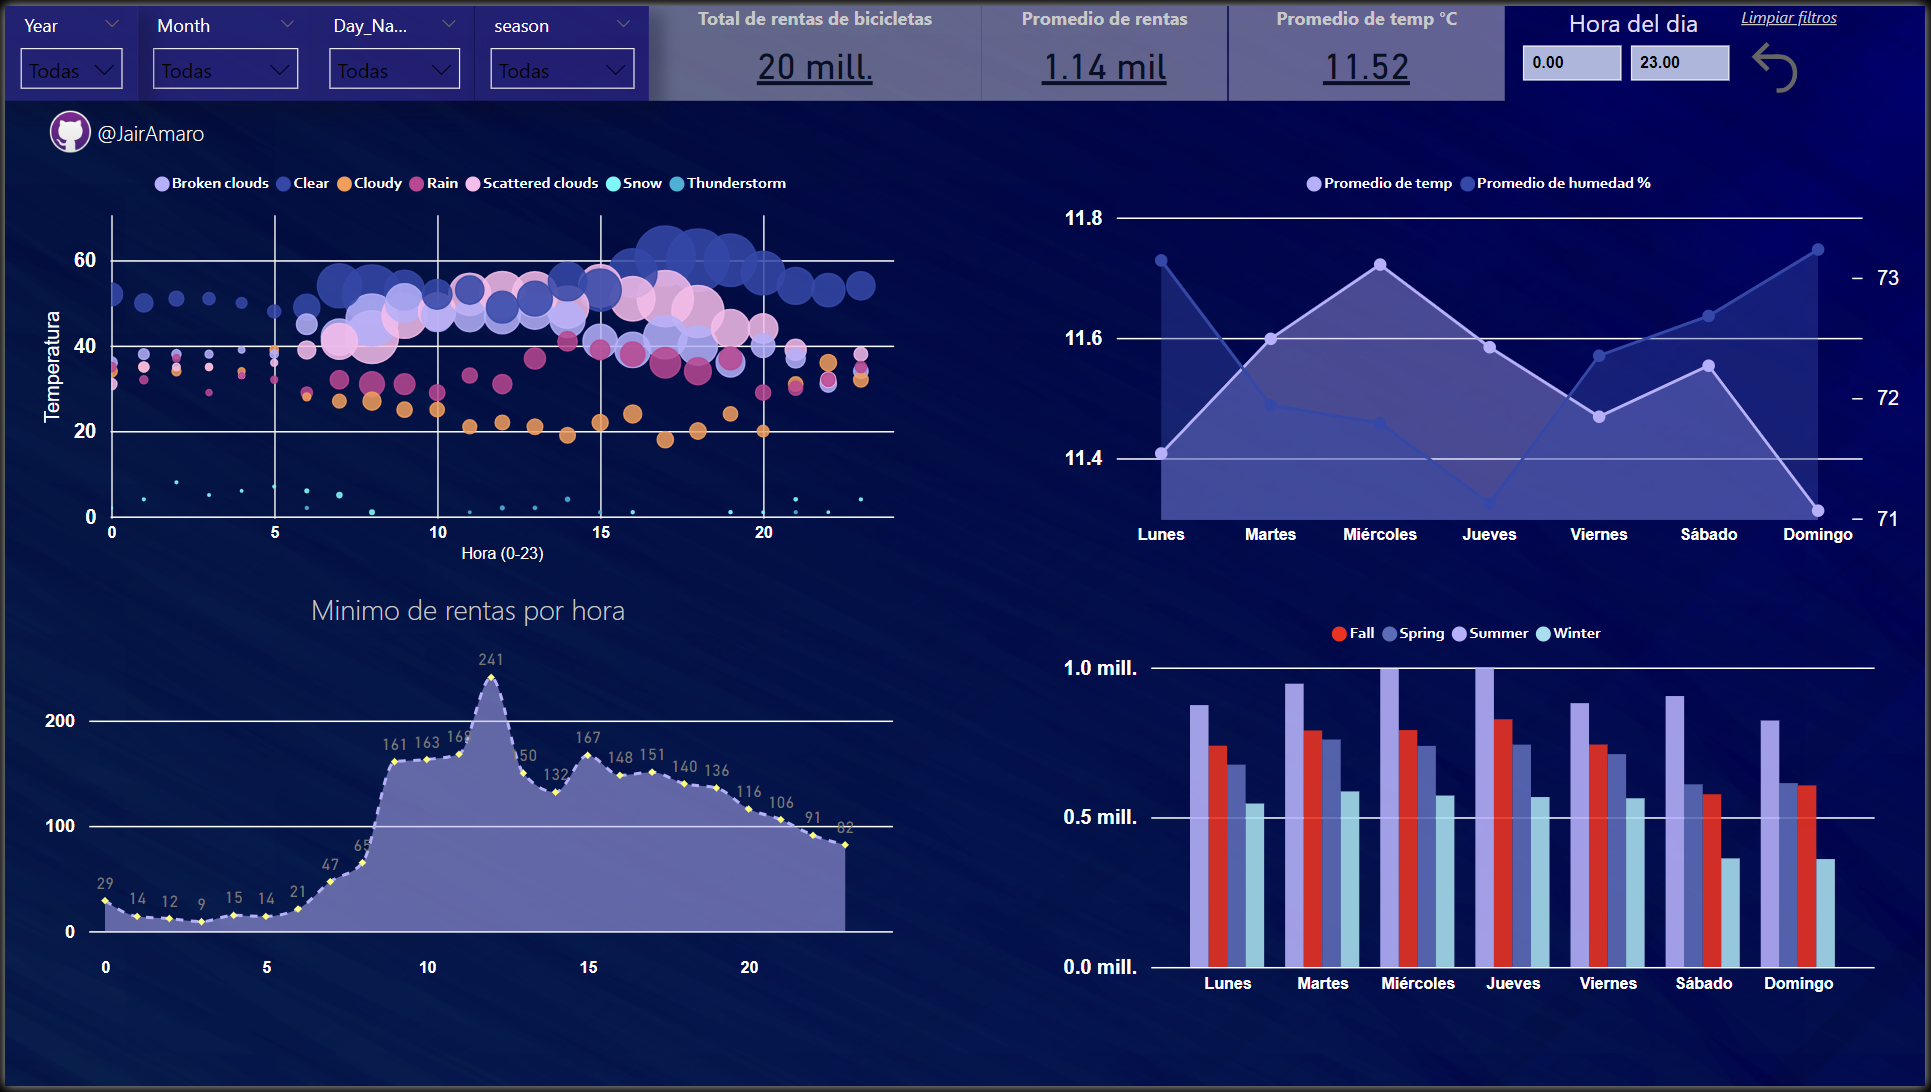

# Vizuallizaciones en dashboard con filtros
* Donde filtramos por hora ( 9 am a 19 pm)
* En los años 2015 y 2016
* Por estacion del año Fall y spring
* Sleccioando meses de interes
* Nos da el total de bicletas rentadas en esos filtros como la temperatura promedio 

Sirve para detectar insights y patrones en los datos, sobre todo en horas 

Tambien podemos ver el promedio de la temperatura y huemdad

Como en un inicio nos planteamos con las preguntas inicales, es un dash simple pero interactivo 

Por ejemplo de la grafica Minimo de rentas por hora sabemos que es lo que al menos se rentan si ubicamos una tendencia por las horas entre picos y conforme a su stock si es que se deben aumentar o disminuir bicicletas en stock, conforme a la demanda

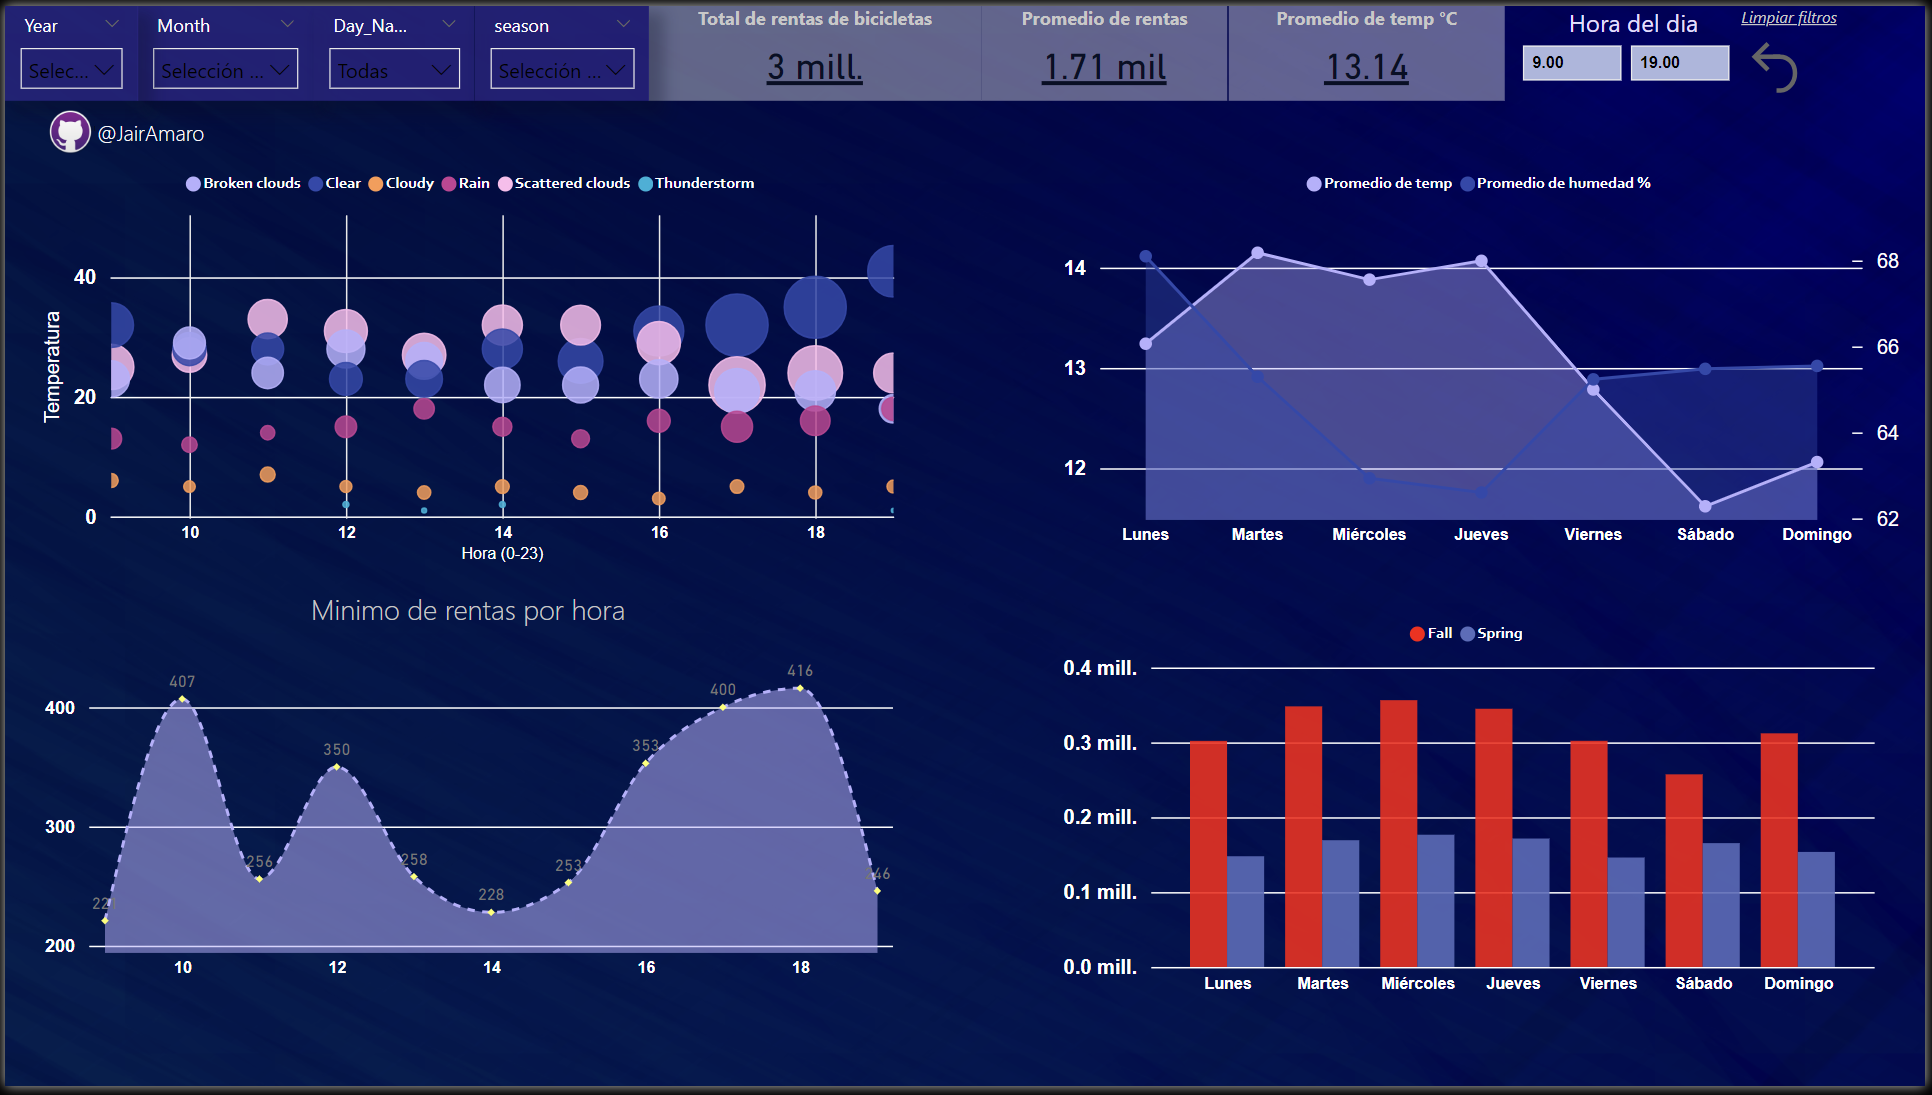

# Correlacion entre variables

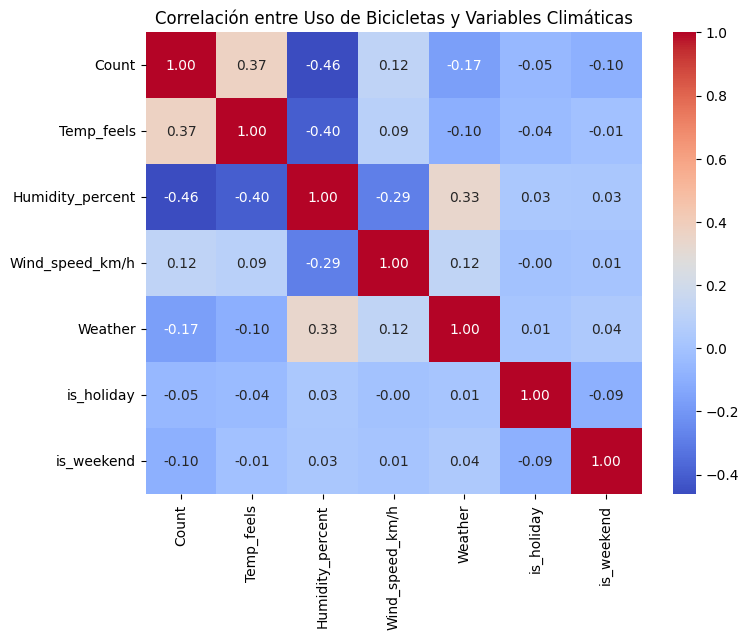

In [10]:
# Calculando la matriz de correlación
correlation_matrix = df[['Count', 'Temp_feels', 'Humidity_percent', 'Wind_speed_km/h', 'Weather', 'is_holiday','is_weekend' ]].corr()

# Visualizando la matriz de correlación con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlación entre Uso de Bicicletas y Variables Climáticas')
plt.show()

## Temperatura Percibida

* La temperatura tiene una correlación positiva (0.37) con el uso de bicicletas.
Insight: Cuando las temperaturas son más altas, se observa un aumento en el uso de bicicletas


* Existe una correlación negativa moderada (-0.46) entre la humedad y el uso de bicicletas.
Insight: Niveles más altos de humedad tienden a disminuir la cantidad de usuarios de bicicletas, probablemente debido a la incomodidad que causa
Velocidad del Viento

* Hay una correlación positiva muy débil (0.12) con el uso de bicicletas, lo cual es estadísticamente poco significativo
Insight: La velocidad del viento parece tener un impacto mínimo en la decisión de las personas de usar bicicletas


Conclusiones para el Cliente: 

La temperatura percibida es el factor climático con mayor influencia en el uso de bicicletas, seguido por la humedad. 

La velocidad del viento es menos relevante para predecir este comportamiento. Estos hallazgos pueden guiar estrategias de marketing y operaciones, especialmente en la promoción del uso de bicicletas en días cálidos y menos húmedos.

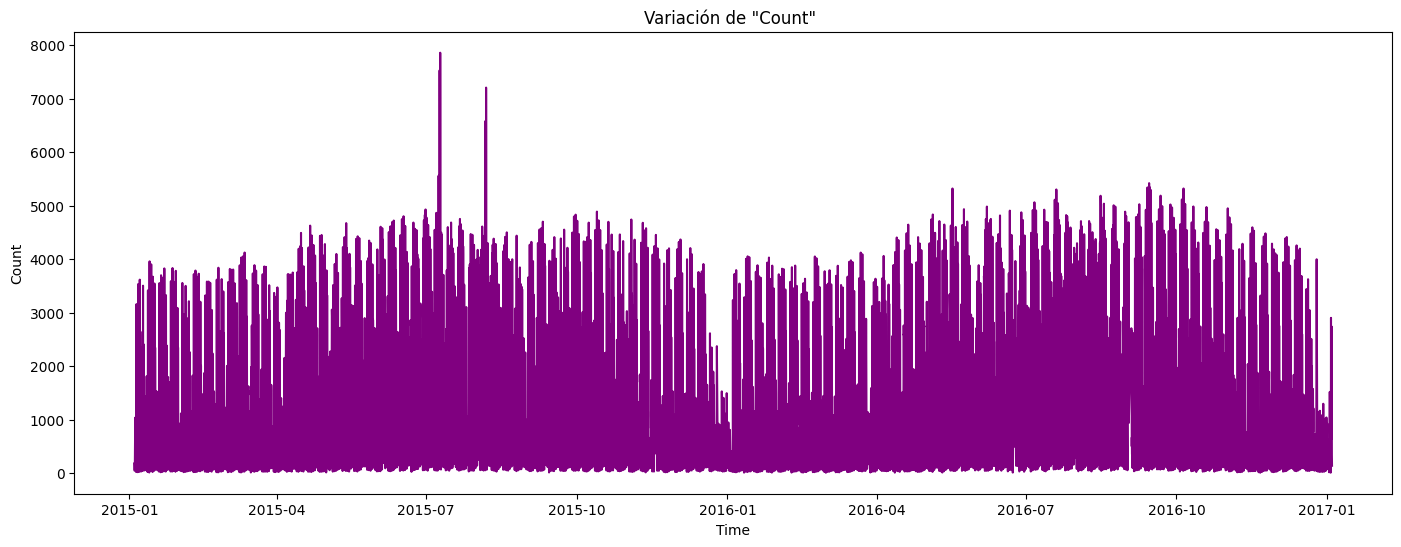

In [11]:
def PlotCountByYear(data):
    plt.figure(figsize=(17, 6))
    sns.lineplot(x='Time', y='Count', data=data, color='purple')
    plt.title('Variación de "Count" ')
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.show()


PlotCountByYear(df)

In [12]:
df_2016 = df[df['Year'] == 2016]
df_2015 = df[df['Year'] == 2015]

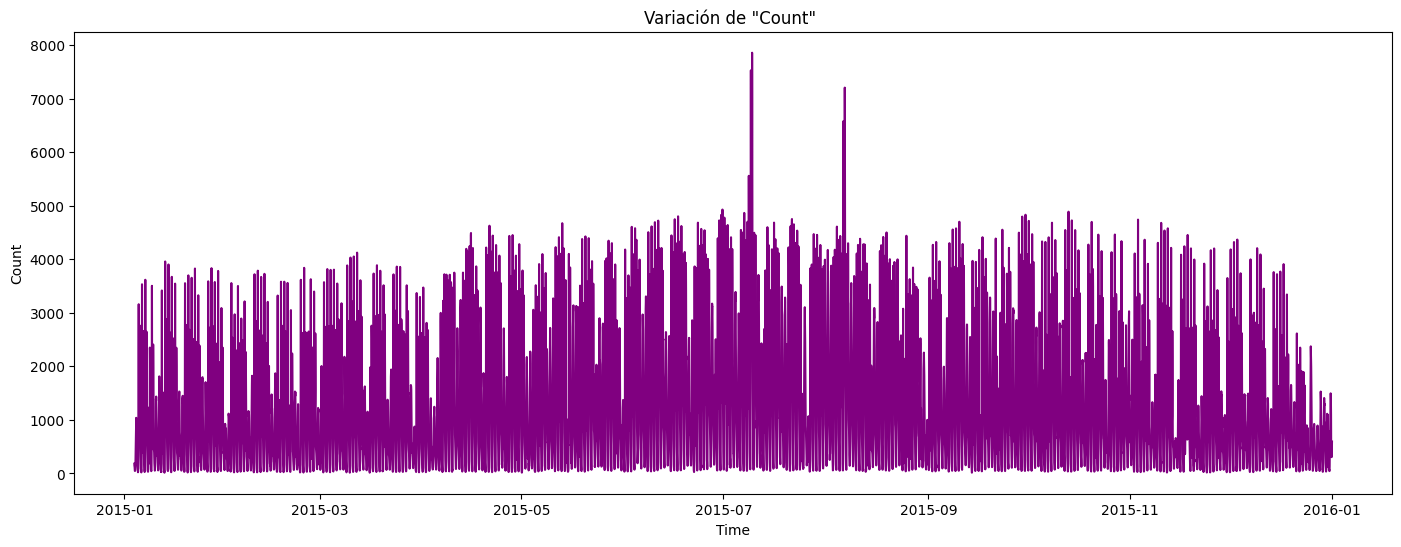

In [13]:
PlotCountByYear(df_2015)

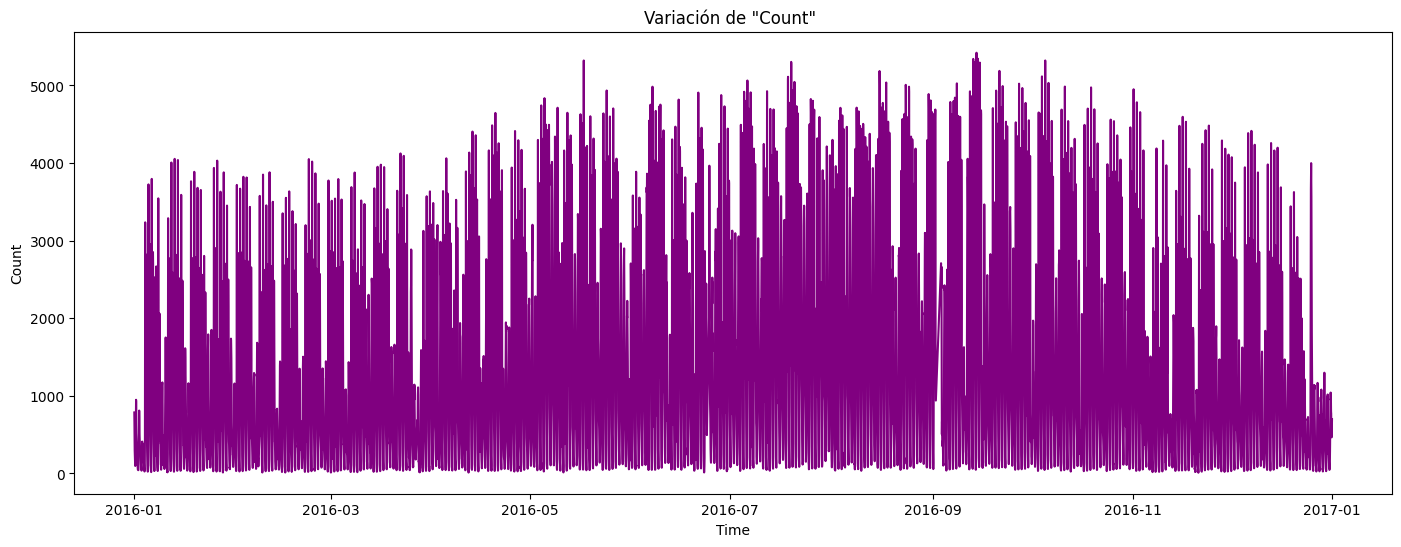

In [14]:
PlotCountByYear(df_2016)

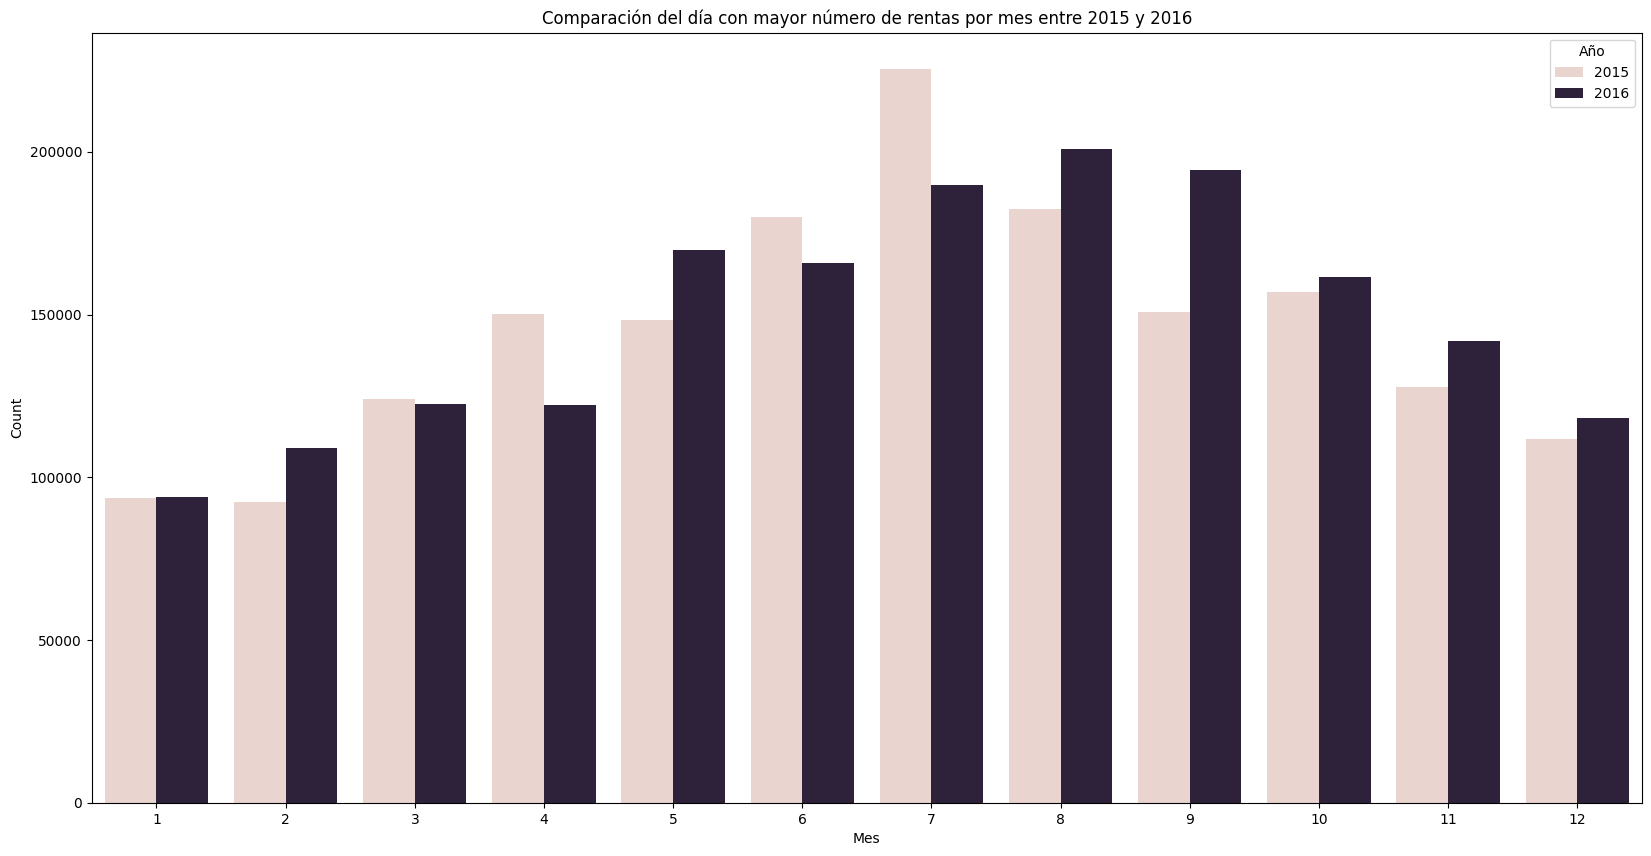

In [15]:
df_filtered = df[df['Year'].isin([2015, 2016])]
# Agrupar por año, mes y día, sumando 'Count'
daily_counts = df_filtered.groupby(['Year', 'Month', 'day_of_week'])['Count'].sum().reset_index()
# Encontrar el día con el máximo 'Count' para cada mes de cada año
max_days_per_month = daily_counts.loc[daily_counts.groupby(['Year', 'Month'])['Count'].idxmax()]
# Ahora podemos graficar los resultados con ambos años en la misma gráfica
plt.figure(figsize=(20, 10))
sns.barplot(x='Month', y='Count', hue='Year', data=max_days_per_month, dodge=True)
plt.title('Comparación del día con mayor número de rentas por mes entre 2015 y 2016')
plt.xlabel('Mes')
plt.ylabel('Count')
plt.legend(title='Año')
plt.show()

No podemos comparar como tal un dia del año 2015 con el 2016, ya que no tenemos datos de los mismos dias en ambos años, es decir el domingo 1 de enero de 2015 no es el mismo que el domingo 1 de enero de 2016, por lo que no podemos compararlos directamente como tal pero si podemos intentar saber que dia se renta mas es decir si los domingos se renta mas por fin de semana

# 2. Preparar los datos

En el contexto de un sistema de bicicletas compartidas, normalmente el "conteo" es la métrica de mayor interés para la empresa o servicio, ya que representa directamente el uso del servicio. Por lo tanto, si tu objetivo es optimizar la cantidad de bicicletas disponibles, mejorar el servicio o entender los patrones de uso, objetivo es analizar o predecir el uso de bicicletas compartidas, entonces "cnt", que representa el "conteo de nuevos compartidos de bicicletas", sería la variable objetivo la cual llamamos Count

* Realizar la detección de valores atípicos (outliers) es una práctica estándar en el análisis de datos

* Q1 = Calcula el primer cuartil (Q1) de los datos de "Count". Esto es el valor por debajo del cual se encuentra el 25% de los datos
* Q3 = Calcula el tercer cuartil (Q3) de los datos de "Count". Esto es el valor por debajo del cual se encuentra el 75% de los datos
* IQR = Q3 - Q1: Calcula el rango intercuartílico (IQR), que es la diferencia entre Q3 y Q1 y representa el rango dentro del cual se encuentra el 50% central de los datos

lower_limit = Q1 - 1.5 * IQR: Esto calcula el límite inferior. Cualquier valor de "Count" que sea menor que este límite se consideraría un valor atípico extremadamente bajo.

upper_limit = Q3 + 1.5 * IQR: Esto calcula el límite superior. Cualquier valor de "Count" que sea mayor que este límite se consideraría un valor atípico extremadamente alto.

Los valores que están fuera de estos límites se consideran alejados de la variación "típica" de los datos y pueden ser sujetos a un análisis adicional


In [16]:
Quantil_1 = df['Count'].quantile(0.25)
Quantil_3 = df['Count'].quantile(0.75)
IQR = Quantil_3 - Quantil_1
# LDefinimos los limites para los outliers
Lower_limit = Quantil_1 - 1.5 * IQR
Upper_limit = Quantil_3 + 1.5 * IQR

In [17]:
# Identificar los outliers
outliers = df[(df['Count'] < Lower_limit) | (df['Count'] > Upper_limit)]
sample_outliers = outliers.sample(n=10, random_state=1) # solo mostarra 10 outliers
print('Outliers shape is: ',outliers.shape[0])
# Aplicar el gradiente de fondo a la muestra
styled_sample = sample_outliers.style.background_gradient(cmap='Blues')
styled_sample

Outliers shape is:  672


In [18]:
#removing outliers
df = df[(df['Count'] >= Lower_limit) & (df['Count'] <= Upper_limit)]
print("shape after outliers removal :",df.shape)

shape after outliers removal : (16741, 16)


## Elminar outliers?

Depende del contexto, para esta situacion yo no recomendaria eliminarlos ya que en el contexto de esta data no ha sido manipulada, es dedcir esta 'Limpia' de origen por lo cual si veo posible la cantidad de rentas de 5000 bicletas y velocidades de 26 km/h, por lo que no eliminaria los outliers

Despues de poner en practica algunos modelos decidi que si eliminaria los outliers ya que estos afectan el modelo y no aportan informacion relevante

In [19]:
df_segundo_modelo = df.copy()
df_primer_modelo = df.copy()
df_primer_modelo_bueno = df.copy()

In [20]:
df_segundo_modelo

Time  Count  Real_time  Temp_feels  Humidity_percent  \
0     2015-01-04 00:00:00    182        3.0         2.0              93.0   
1     2015-01-04 01:00:00    138        3.0         2.5              93.0   
2     2015-01-04 02:00:00    134        2.5         2.5              96.5   
3     2015-01-04 03:00:00     72        2.0         2.0             100.0   
4     2015-01-04 04:00:00     47        2.0         0.0              93.0   
...                   ...    ...        ...         ...               ...   
17409 2017-01-03 19:00:00   1042        5.0         1.0              81.0   
17410 2017-01-03 20:00:00    541        5.0         1.0              81.0   
17411 2017-01-03 21:00:00    337        5.5         1.5              78.5   
17412 2017-01-03 22:00:00    224        5.5         1.5              76.0   
17413 2017-01-03 23:00:00    139        5.0         1.0              76.0   

       Wind_speed_km/h  Weather  is_holiday  is_weekend  season  Year  Month  \
0                  6.0      3.0         0.0         1.0     3.0  2015      1   
1                  5.0      1.0         0.0         1.0     3.0  2015      1   
2                  0.0      1.0         0.0         1.0     3.0  2015      1   
3                  0.0      1.0         0.0         1.0     3.0  2015      1   
4                  6.5      1.0         0.0         1.0     3.0  2015      1   
...                ...      ...         ...         ...     ...   ...    ...   
17409             19.0      3.0         0.0         0.0     3.0  2017      1   
17410             21.0      4.0         0.0         0.0     3.0  2017      1   
17411             24.0      4.0         0.0         0.0     3.0  2017      1   
17412             23.0      4.0         0.0         0.0     3.0  2017      1   
17413             22.0      2.0         0.0         0.0     3.0  2017      1   

       day_of_week  Day_of_month  week_of_year  Hour  
0                6             4             1     0  
1                6             4             1     1  
2                6             4             1     2  
3                6             4             1     3  
4                6             4             1     4  
...            ...           ...           ...   ...  
17409            1             3             1    19  
17410            1             3             1    20  
17411            1             3             1    21  
17412            1             3             1    22  
17413            1             3             1    23  

[16741 rows x 16 columns]

# Analisis exploratorio de datos (EDA) para el primer modelo
Esto es para tener ideas y no revolver todo en un solo EDA 

In [21]:
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)

In [22]:
# Remuestreo semanal
weekly = df.resample('W').mean()
# Remuestreo mensual
monthly = df.resample('M').mean()
# Remuestreo semestral
semi_monthly = df.resample('SM').mean()
# Remuestreo trimestral
quarterly = df.resample('Q').mean()

In [23]:
quarterly

Count  Real_time  Temp_feels  Humidity_percent  \
Time                                                               
2015-03-31   836.640678   6.689831    4.175787         74.373729   
2015-06-30  1126.056676  13.680355   13.155139         65.034582   
2015-09-30  1178.499756  17.316431   17.287908         69.215748   
2015-12-31   908.048598  12.224533   11.698832         78.028271   
2016-03-31   817.310280   7.188785    4.918692         74.836449   
2016-06-30  1099.266086  13.277455   12.692066         71.050798   
2016-09-30  1261.601107  19.239185   19.228873         67.739940   
2016-12-31   932.152622   9.557272    8.414716         80.321863   
2017-03-31   523.333333   4.708333    1.583333         84.326389   

            Wind_speed_km/h   Weather  is_holiday  is_weekend    season  \
Time                                                                      
2015-03-31        16.982446  3.161743    0.000000    0.289588  1.942373   
2015-06-30        17.213497  2.329011    0.046110    0.299232  0.319885   
2015-09-30        14.731107  2.462214    0.011702    0.296441  1.330083   
2015-12-31        17.583022  3.157477    0.022430    0.289252  2.342523   
2016-03-31        17.537150  3.092056    0.033645    0.283645  1.986449   
2016-06-30        14.585631  2.798742    0.023222    0.298500  0.323657   
2016-09-30        15.349849  2.250503    0.012072    0.297284  1.314889   
2016-12-31        13.122269  2.764045    0.022472    0.301966  2.343165   
2017-03-31        14.743056  3.263889    0.333333    0.333333  3.000000   

              Year      Month  day_of_week  Day_of_month  week_of_year  \
Time                                                                     
2015-03-31  2015.0   2.029540     2.988862     15.974818      7.549153   
2015-06-30  2015.0   4.984630     3.052354     15.588857     20.199328   
2015-09-30  2015.0   7.999512     3.044856     15.964408      33.41492   
2015-12-31  2015.0  11.009346     3.028037     15.907944     46.546729   
2016-03-31  2016.0   1.993925     2.999065     15.621495      8.320093   
2016-06-30  2016.0   4.985002     3.031447     15.628931     19.495888   
2016-09-30  2016.0   7.969819     3.053320     16.020624     32.575956   
2016-12-31  2016.0  11.014513     3.057584     15.885768     45.847846   
2017-03-31  2017.0   1.000000     2.333333      2.000000          18.0   

                 Hour  
Time                   
2015-03-31  11.542373  
2015-06-30  11.444765  
2015-09-30  11.376402  
2015-12-31  11.560280  
2016-03-31  11.561682  
2016-06-30  11.472182  
2016-09-30  11.276660  
2016-12-31  11.519663  
2017-03-31  11.500000

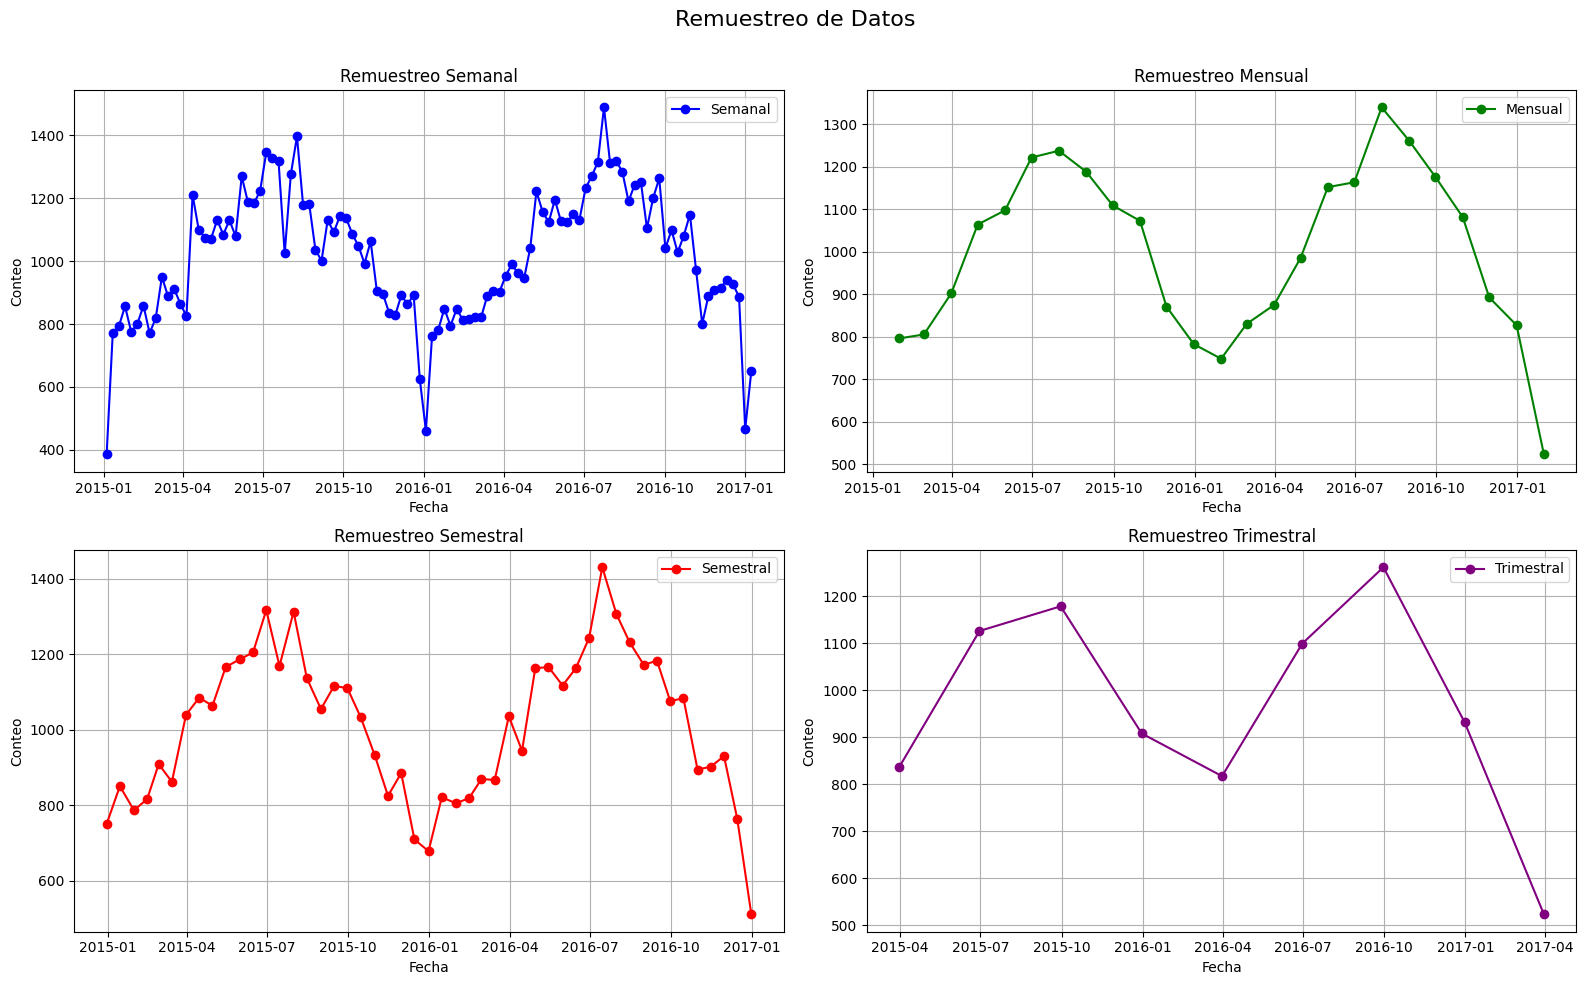

In [24]:
# Configurar la figura de subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
fig.suptitle('Remuestreo de Datos', fontsize=16)

# Graficar remuestreo semanal
axes[0, 0].plot(weekly.index, weekly['Count'], label='Semanal', marker='o', color='blue')
axes[0, 0].set_title('Remuestreo Semanal')
axes[0, 0].set_xlabel('Fecha')
axes[0, 0].set_ylabel('Conteo')
axes[0, 0].grid(True)
axes[0, 0].legend()

# Graficar remuestreo mensual
axes[0, 1].plot(monthly.index, monthly['Count'], label='Mensual', color='green', marker='o')
axes[0, 1].set_title('Remuestreo Mensual')
axes[0, 1].set_xlabel('Fecha')
axes[0, 1].set_ylabel('Conteo')
axes[0, 1].grid(True)
axes[0, 1].legend()

# Graficar remuestreo semestral
axes[1, 0].plot(semi_monthly.index, semi_monthly['Count'], label='Semestral', color='red', marker='o')
axes[1, 0].set_title('Remuestreo Semestral')
axes[1, 0].set_xlabel('Fecha')
axes[1, 0].set_ylabel('Conteo')
axes[1, 0].grid(True)
axes[1, 0].legend()

# Graficar remuestreo trimestral
axes[1, 1].plot(quarterly.index, quarterly['Count'], label='Trimestral', color='purple', marker='o')
axes[1, 1].set_title('Remuestreo Trimestral')
axes[1, 1].set_xlabel('Fecha')
axes[1, 1].set_ylabel('Conteo')
axes[1, 1].grid(True)
axes[1, 1].legend()

# Ajustar los subplots para evitar que se solapen
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Ajusta el espacio en la parte superior para el título global

# Mostrar la figura
plt.show()

---
# 3.1 XGBoost Modelo (MALO)
Primewro haremos un modelo sencillo pero MALO para asi interpretar los resultados y mejorarlos

In [25]:
df_primer_modelo.head(2)

Time  Count  Real_time  Temp_feels  Humidity_percent  \
0 2015-01-04 00:00:00    182        3.0         2.0              93.0   
1 2015-01-04 01:00:00    138        3.0         2.5              93.0   

   Wind_speed_km/h  Weather  is_holiday  is_weekend  season  Year  Month  \
0              6.0      3.0         0.0         1.0     3.0  2015      1   
1              5.0      1.0         0.0         1.0     3.0  2015      1   

   day_of_week  Day_of_month  week_of_year  Hour  
0            6             4             1     0  
1            6             4             1     1

In [26]:
X = df_primer_modelo.drop(['Time','Count', 'Year', 'Month', 'day_of_week','Day_of_month', 'week_of_year','Hour'],axis=1)
y = df_primer_modelo['Count']

In [27]:
def df_split(X, y, train_percent):
    split_index = int(train_percent * len(X))
    
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:]
    
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = df_split(X, y, 0.7)

In [28]:
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_log_error,mean_squared_error, make_scorer

In [29]:
xgbmodel = XGBRegressor()
xgbmodel.fit(X_train,y_train)

preds = xgbmodel.predict(X_test)

In [30]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 766.689056


RMSE (Root Mean Squared Error): Es una medida de la diferencia entre los valores predichos por el modelo y los valores observados. 

Un RMSE de 766.69 sugiere que, en promedio, las predicciones del modelo están a 766.69 unidades de los valores reales en el conjunto de prueba

In [31]:
y_test.values

array([ 54, 116, 760, ..., 337, 224, 139], dtype=int64)

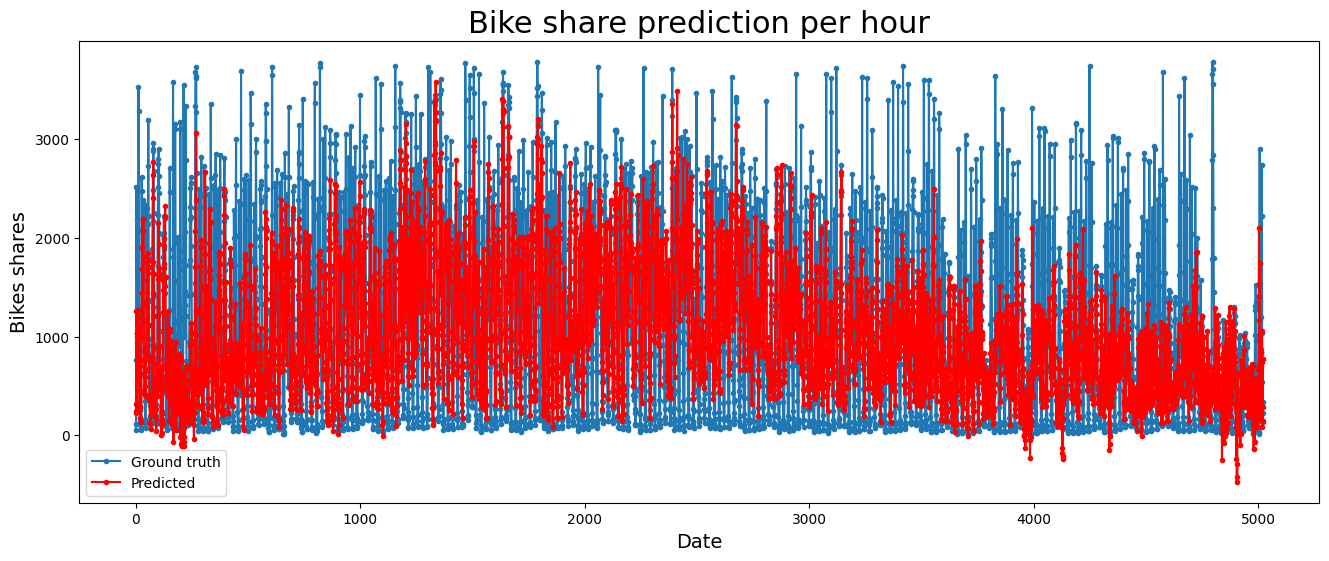

In [32]:
plt.figure(figsize=(16,6))
plt.plot(y_test.values, marker=".", label="actual")
plt.plot(preds, marker=".", label="prediction", color="r")

plt.title('Bike share prediction per hour', fontsize=22)
plt.xlabel(xlabel='Date', fontsize=14)
plt.ylabel(ylabel='Bikes shares', fontsize=14)
plt.legend(['Ground truth', 'Predicted'])

plt.show()

Análisis del Gráfico
Tendencia Capturada por el Modelo:

* Las predicciones del modelo (en rojo) siguen la tendencia general de los valores reales (en azul). Esto sugiere que el modelo XGBoost ha capturado adecuadamente la tendencia general de los datos


Diferencias Entre Predicciones y Valores Reales:

* A pesar de que el modelo sigue la tendencia general, existen diferencias notables entre las predicciones y los valores reales. Esto se observa en las discrepancias entre las líneas roja y azul

* La variabilidad de los valores reales es alta, lo que puede dificultar la tarea de predicción precisa para el modelo


Distribución de los Datos:

* Los datos están bastante dispersos a lo largo del tiempo, con picos y valles significativos en la cantidad de bicicletas compartidas. Esto indica que hay factores externos que afectan fuertemente la demanda de bicicletas y que podrían no haber sido capturados completamente por el modelo

Interpretación de la Evaluación del Modelo

El RMSE (Error Cuadrático Medio) de aproximadamente 766.69 indica que, en promedio, las predicciones del modelo están a 766.69 unidades de los valores reales. Esto sugiere que aunque el modelo es capaz de capturar la tendencia general, todavía hay un margen significativo de error en las predicciones


El modelo XGBoost ha capturado la tendencia general de los datos, pero hay una diferencia considerable entre las predicciones y los valores reales, veamos con redes neuronales

---

EL MODELO ES MALO 
Ya que la linea roja representa la media pero es trivialmnete hacerlo en una hoja, o para otro tipo de cliente si sabemos que este cliente renta demasiadas bicletas es muy facil intuir que la media seria eso pero al final no prodecimos algo correcto enfocado a la empresa que renta demasidas (supongamos que es de las mejores) esto tal vcez solo serviria si fuere una empresa que no rentara lo que hace 

---


# 3.2 XGBoost Modelling (Modelo BUENO)

In [33]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

In [34]:
df_primer_modelo_bueno.head(2)

Time  Count  Real_time  Temp_feels  Humidity_percent  \
0 2015-01-04 00:00:00    182        3.0         2.0              93.0   
1 2015-01-04 01:00:00    138        3.0         2.5              93.0   

   Wind_speed_km/h  Weather  is_holiday  is_weekend  season  Year  Month  \
0              6.0      3.0         0.0         1.0     3.0  2015      1   
1              5.0      1.0         0.0         1.0     3.0  2015      1   

   day_of_week  Day_of_month  week_of_year  Hour  
0            6             4             1     0  
1            6             4             1     1

In [35]:
# Asegurarse de que la columna 'Time' es de tipo datetime
df_primer_modelo_bueno['Time'] = pd.to_datetime(df_primer_modelo_bueno['Time'])

# Crear nuevas características basadas en el tiempo
df_primer_modelo_bueno['Hour_sin'] = np.sin(df_primer_modelo_bueno['Hour'] * (2. * np.pi / 24))
df_primer_modelo_bueno['Hour_cos'] = np.cos(df_primer_modelo_bueno['Hour'] * (2. * np.pi / 24))
df_primer_modelo_bueno['Day_of_week_sin'] = np.sin(df_primer_modelo_bueno['day_of_week'] * (2. * np.pi / 7))
df_primer_modelo_bueno['Day_of_week_cos'] = np.cos(df_primer_modelo_bueno['day_of_week'] * (2. * np.pi / 7))

# La explicacion del por que cos y sin es por que se necesita una representacion ciclica, mas abajo en el segundo modelo explico mas a detalle el por que

In [36]:
# Seleccionar las características y la variable objetivo
df_X = df_primer_modelo_bueno.drop(labels=["Count", "Time"], axis=1)
df_Y = df_primer_modelo_bueno["Count"]

In [37]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42)


In [38]:
# Escalar las características
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
scaler_Y = MinMaxScaler()
y_train_scaled = scaler_Y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_Y.transform(y_test.values.reshape(-1, 1)).flatten()

In [39]:
# Crear el modelo XGBoost
xgb_model = xgb.XGBRegressor()

# Definir los parámetros para Grid Search
# Estos son solo algunos de los parámetros que se pueden ajustar
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [40]:
# Realizar Grid Search con validación cruzada
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [41]:
# Mejor modelo encontrado por Grid Search
best_xgb_model = grid_search.best_estimator_

# Entrenar el mejor modelo
best_xgb_model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [42]:
# Realizar predicciones
y_pred_scaled = best_xgb_model.predict(X_test_scaled)

# Reescalar las predicciones
y_pred = scaler_Y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test = scaler_Y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

In [43]:
# Evaluar el modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse} ')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

RMSE: 147.0301876464352 
MAE: 88.53928644521338
R2 Score: 0.9725751976648246


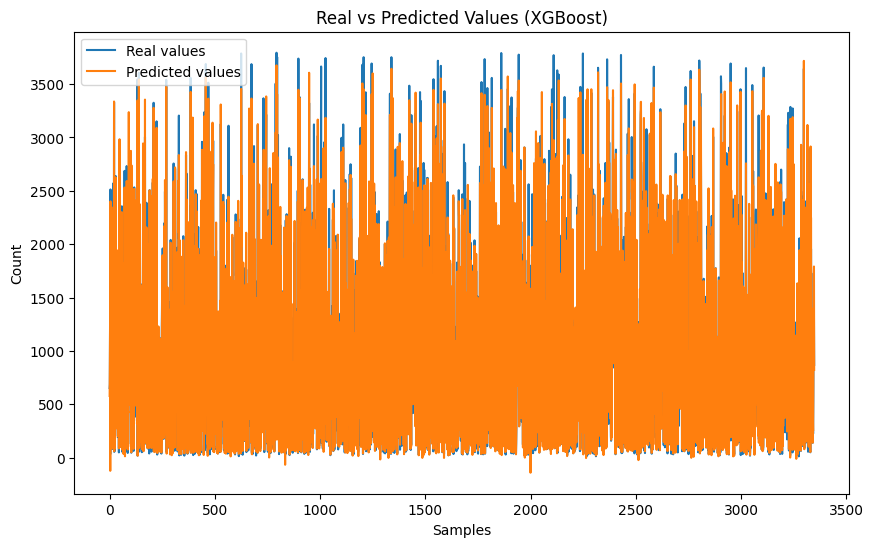

In [44]:
# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Real values')
plt.plot(y_pred, label='Predicted values')
plt.title('Real vs Predicted Values (XGBoost)')
plt.xlabel('Samples')
plt.ylabel('Count')
plt.legend()
plt.show()

In [45]:
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
# Calcular las predicciones
y_pred = best_xgb_model.predict(X_test_scaled)

# Reescalar las predicciones
y_pred_rescaled = scaler_Y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_Y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Definir un umbral para convertir la regresión en clasificación
threshold = 1000

# Transformar los valores reales y predichos en clases binarias
y_test_class = (y_test_rescaled >= threshold).astype(int)
y_pred_class = (y_pred_rescaled >= threshold).astype(int)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
tn, fp, fn, tp = conf_matrix.ravel()

# Calcular el reporte de clasificación
class_report = classification_report(y_test_class, y_pred_class, target_names=['Below Threshold', 'Above Threshold'])

# Calcular las métricas de efectividad del modelo
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Crear un DataFrame con las métricas de efectividad del modelo
df_model_effectiveness = pd.DataFrame({
    'Modelo': ['XGBoost'],
    'MSE': [mse],
    'RMSE': [rmse],
    'MAE': [mae],
    'R²': [r2],
    'TP': [tp],
    'FP': [fp],
    'TN': [tn],
    'FN': [fn],
    'Precisión': [tp / (tp + fp)],
    'Recall': [tp / (tp + fn)],
    'F1-Score': [2 * (tp / (tp + fp) * tp / (tp + fn)) / ((tp / (tp + fp)) + (tp / (tp + fn)))],
    'Efectividad del Modelo': ['Buena']
})


In [46]:
# Mostrar el DataFrame de efectividad del modelo
df_model_effectiveness

Modelo           MSE        RMSE        MAE        R²    TP  FP    TN  FN  \
0  XGBoost  21617.876079  147.030188  88.539286  0.972575  1341  76  1882  50   

   Precisión    Recall  F1-Score Efectividad del Modelo  
0   0.946366  0.964055  0.955128                  Buena

In [47]:
print("\nReporte de Clasificación:\n", class_report)


Reporte de Clasificación:
                  precision    recall  f1-score   support

Below Threshold       0.97      0.96      0.97      1958
Above Threshold       0.95      0.96      0.96      1391

       accuracy                           0.96      3349
      macro avg       0.96      0.96      0.96      3349
   weighted avg       0.96      0.96      0.96      3349



In [48]:
# Crear un DataFrame con los valores reales y las predicciones
df_results_XGBoost = pd.DataFrame({
    'Real Values': y_test,
    'Predicted Values': y_pred
})

# Mostrar las primeras filas del DataFrame
print(df_results_XGBoost.head())

   Real Values  Predicted Values
0        652.0          0.150380
1        686.0          0.218398
2       1205.0          0.326592
3         32.0         -0.035014
4       2513.0          0.632050


Al final interpretaremos y compararemos estos resultados con el segundo modelo

# EDA para el segundo modelo (LTML)

In [49]:
df_segundo_modelo['Hour'] = df_segundo_modelo['Time'].dt.hour
df_segundo_modelo

Time  Count  Real_time  Temp_feels  Humidity_percent  \
0     2015-01-04 00:00:00    182        3.0         2.0              93.0   
1     2015-01-04 01:00:00    138        3.0         2.5              93.0   
2     2015-01-04 02:00:00    134        2.5         2.5              96.5   
3     2015-01-04 03:00:00     72        2.0         2.0             100.0   
4     2015-01-04 04:00:00     47        2.0         0.0              93.0   
...                   ...    ...        ...         ...               ...   
17409 2017-01-03 19:00:00   1042        5.0         1.0              81.0   
17410 2017-01-03 20:00:00    541        5.0         1.0              81.0   
17411 2017-01-03 21:00:00    337        5.5         1.5              78.5   
17412 2017-01-03 22:00:00    224        5.5         1.5              76.0   
17413 2017-01-03 23:00:00    139        5.0         1.0              76.0   

       Wind_speed_km/h  Weather  is_holiday  is_weekend  season  Year  Month  \
0                  6.0      3.0         0.0         1.0     3.0  2015      1   
1                  5.0      1.0         0.0         1.0     3.0  2015      1   
2                  0.0      1.0         0.0         1.0     3.0  2015      1   
3                  0.0      1.0         0.0         1.0     3.0  2015      1   
4                  6.5      1.0         0.0         1.0     3.0  2015      1   
...                ...      ...         ...         ...     ...   ...    ...   
17409             19.0      3.0         0.0         0.0     3.0  2017      1   
17410             21.0      4.0         0.0         0.0     3.0  2017      1   
17411             24.0      4.0         0.0         0.0     3.0  2017      1   
17412             23.0      4.0         0.0         0.0     3.0  2017      1   
17413             22.0      2.0         0.0         0.0     3.0  2017      1   

       day_of_week  Day_of_month  week_of_year  Hour  
0                6             4             1     0  
1                6             4             1     1  
2                6             4             1     2  
3                6             4             1     3  
4                6             4             1     4  
...            ...           ...           ...   ...  
17409            1             3             1    19  
17410            1             3             1    20  
17411            1             3             1    21  
17412            1             3             1    22  
17413            1             3             1    23  

[16741 rows x 16 columns]

In [50]:
# converting discrete variable "season" to bins
df_segundo_modelo = pd.get_dummies(df_segundo_modelo, columns=['season'], dtype=int)
df_segundo_modelo.head()


Time  Count  Real_time  Temp_feels  Humidity_percent  \
0 2015-01-04 00:00:00    182        3.0         2.0              93.0   
1 2015-01-04 01:00:00    138        3.0         2.5              93.0   
2 2015-01-04 02:00:00    134        2.5         2.5              96.5   
3 2015-01-04 03:00:00     72        2.0         2.0             100.0   
4 2015-01-04 04:00:00     47        2.0         0.0              93.0   

   Wind_speed_km/h  Weather  is_holiday  is_weekend  Year  Month  day_of_week  \
0              6.0      3.0         0.0         1.0  2015      1            6   
1              5.0      1.0         0.0         1.0  2015      1            6   
2              0.0      1.0         0.0         1.0  2015      1            6   
3              0.0      1.0         0.0         1.0  2015      1            6   
4              6.5      1.0         0.0         1.0  2015      1            6   

   Day_of_month  week_of_year  Hour  season_0.0  season_1.0  season_2.0  \
0             4             1     0           0           0           0   
1             4             1     1           0           0           0   
2             4             1     2           0           0           0   
3             4             1     3           0           0           0   
4             4             1     4           0           0           0   

   season_3.0  
0           1  
1           1  
2           1  
3           1  
4           1

C:\Users\oscar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1200x600 with 0 Axes>

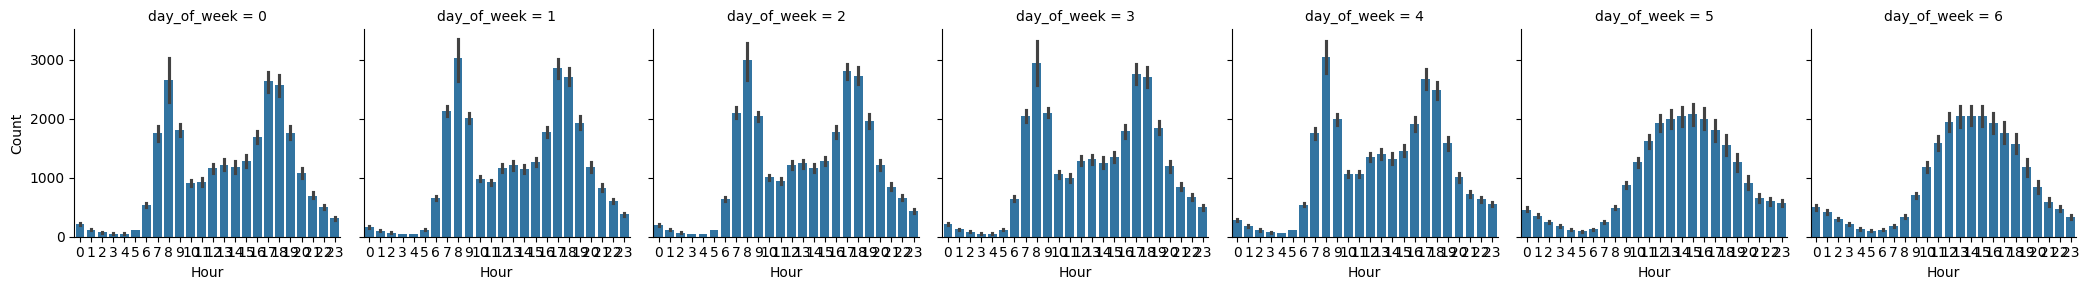

In [51]:
plt.figure(figsize=(12,6))
d = sns.FacetGrid(df_segundo_modelo, col="day_of_week")
d. map(sns.barplot, "Hour", "Count")

Patrones en los Días de Semana (Lunes a Viernes)

Horas Pico:
* Mañana: Alrededor de las 8-9 AM
* Tarde: Alrededor de las 5-6 PM

Interpretación: Estos picos indican que muchas personas utilizan las bicicletas para desplazarse al trabajo o la escuela durante estos horarios, reflejando los patrones típicos de desplazamiento de los días laborales.
Patrones en los Fines de Semana (Sábado y Domingo)

In [52]:
df_segundo_modelo

Time  Count  Real_time  Temp_feels  Humidity_percent  \
0     2015-01-04 00:00:00    182        3.0         2.0              93.0   
1     2015-01-04 01:00:00    138        3.0         2.5              93.0   
2     2015-01-04 02:00:00    134        2.5         2.5              96.5   
3     2015-01-04 03:00:00     72        2.0         2.0             100.0   
4     2015-01-04 04:00:00     47        2.0         0.0              93.0   
...                   ...    ...        ...         ...               ...   
17409 2017-01-03 19:00:00   1042        5.0         1.0              81.0   
17410 2017-01-03 20:00:00    541        5.0         1.0              81.0   
17411 2017-01-03 21:00:00    337        5.5         1.5              78.5   
17412 2017-01-03 22:00:00    224        5.5         1.5              76.0   
17413 2017-01-03 23:00:00    139        5.0         1.0              76.0   

       Wind_speed_km/h  Weather  is_holiday  is_weekend  Year  Month  \
0                  6.0      3.0         0.0         1.0  2015      1   
1                  5.0      1.0         0.0         1.0  2015      1   
2                  0.0      1.0         0.0         1.0  2015      1   
3                  0.0      1.0         0.0         1.0  2015      1   
4                  6.5      1.0         0.0         1.0  2015      1   
...                ...      ...         ...         ...   ...    ...   
17409             19.0      3.0         0.0         0.0  2017      1   
17410             21.0      4.0         0.0         0.0  2017      1   
17411             24.0      4.0         0.0         0.0  2017      1   
17412             23.0      4.0         0.0         0.0  2017      1   
17413             22.0      2.0         0.0         0.0  2017      1   

       day_of_week  Day_of_month  week_of_year  Hour  season_0.0  season_1.0  \
0                6             4             1     0           0           0   
1                6             4             1     1           0           0   
2                6             4             1     2           0           0   
3                6             4             1     3           0           0   
4                6             4             1     4           0           0   
...            ...           ...           ...   ...         ...         ...   
17409            1             3             1    19           0           0   
17410            1             3             1    20           0           0   
17411            1             3             1    21           0           0   
17412            1             3             1    22           0           0   
17413            1             3             1    23           0           0   

       season_2.0  season_3.0  
0               0           1  
1               0           1  
2               0           1  
3               0           1  
4               0           1  
...           ...         ...  
17409           0           1  
17410           0           1  
17411           0           1  
17412           0           1  
17413           0           1  

[16741 rows x 19 columns]

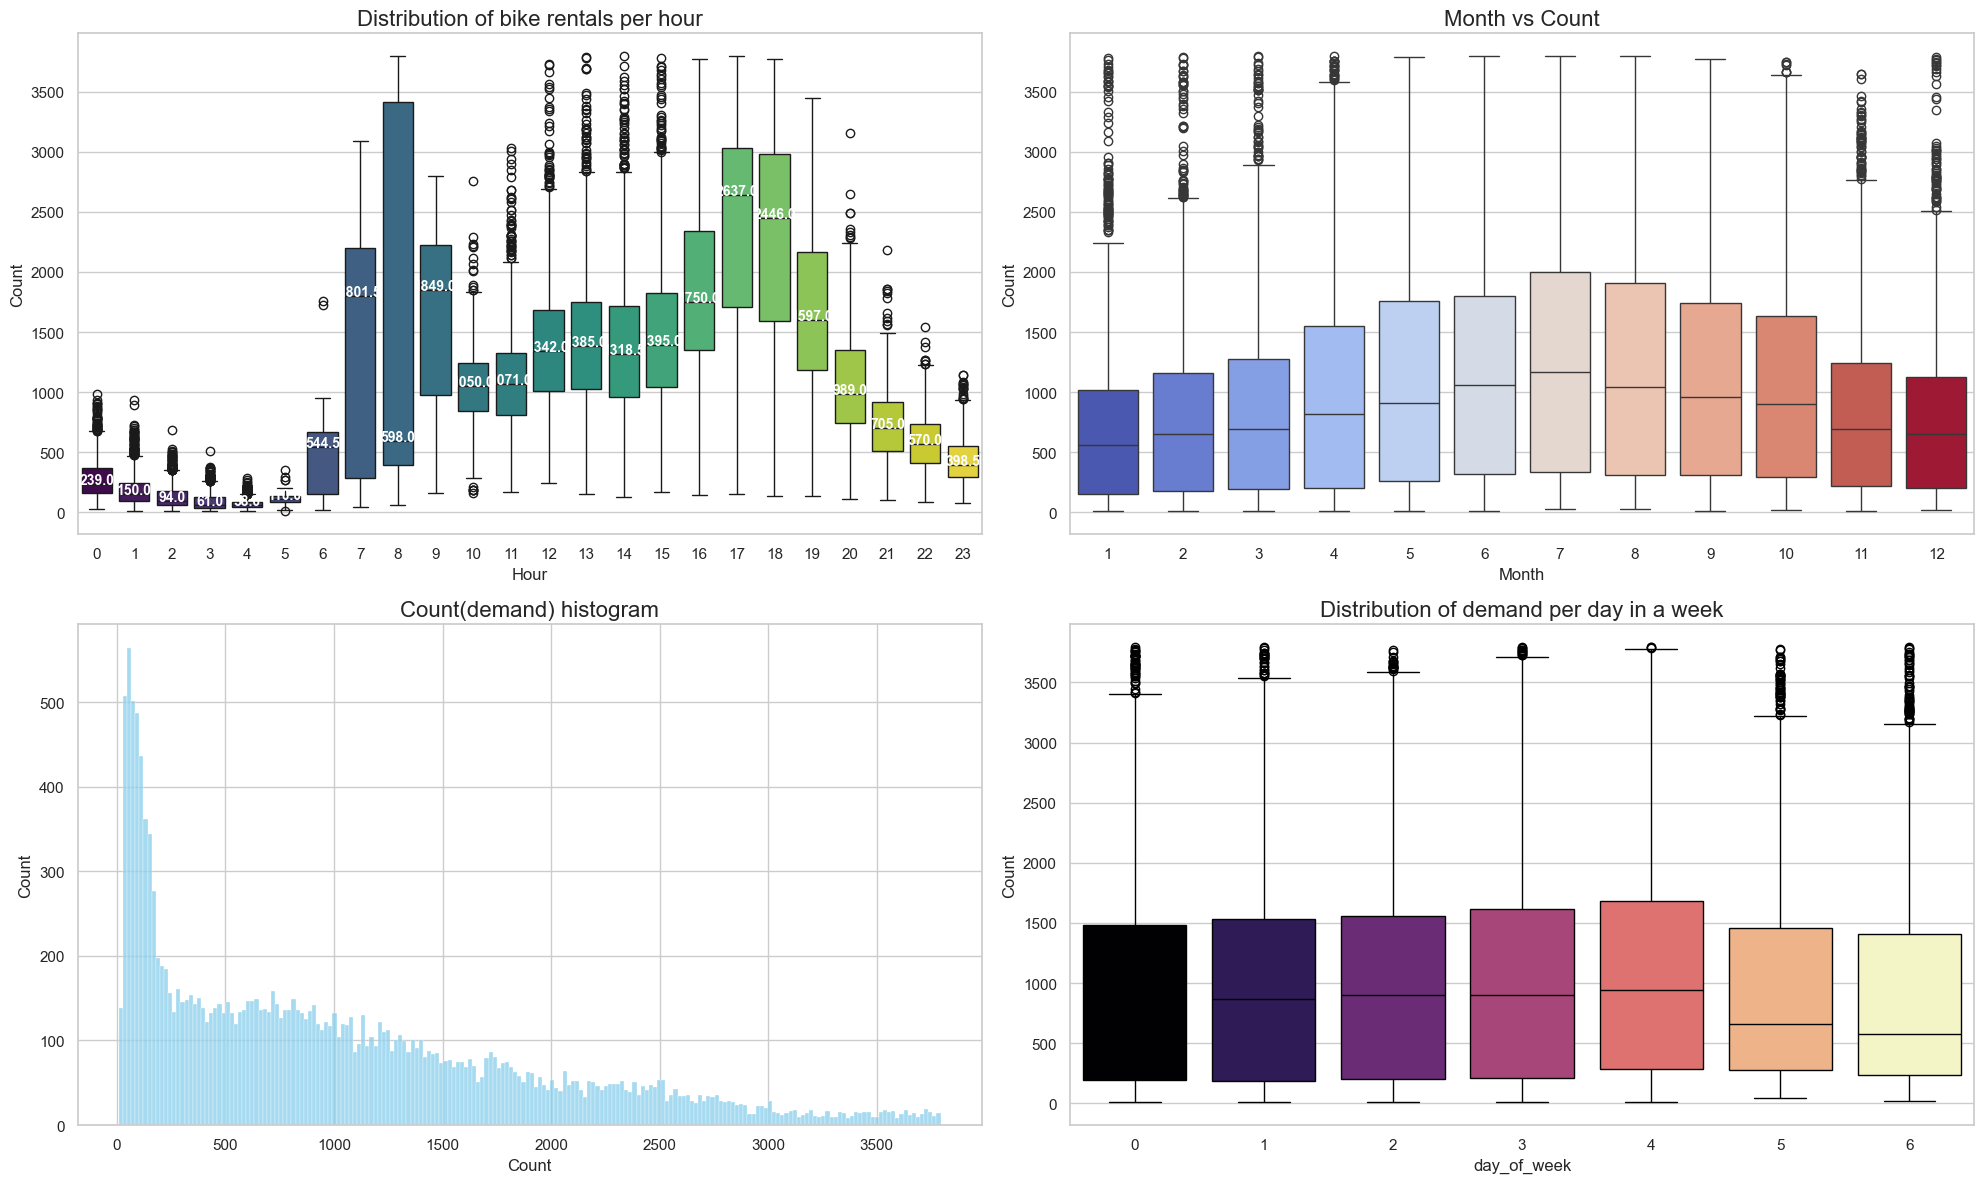

In [53]:
# Estilo decon Seaborn
sns.set(style="whitegrid")

# Creación de la figura con subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Primer gráfico: Distribution of bike rentals per hour
ax1 = axs[0, 0]
sns.boxplot(x='Hour', y='Count', hue='Hour', data=df_segundo_modelo, ax=ax1, palette="viridis", legend=False)
ax1.set_title('Distribution of bike rentals per hour', fontsize=16)
medians = df_segundo_modelo.groupby(['Hour'])['Count'].median().values
for xtick in ax1.get_xticks():
    ax1.text(xtick, medians[xtick], f'{medians[xtick]:.1f}', 
             horizontalalignment='center', size='small', color='white', weight='semibold')

# Segundo gráfico: Month vs Count
ax2 = axs[0, 1]
sns.boxplot(x='Month', y='Count', hue='Month', data=df_segundo_modelo, ax=ax2, palette="coolwarm", legend=False)
ax2.set_title('Month vs Count', fontsize=16)

# Tercer gráfico: Count(demand) histogram
ax3 = axs[1, 0]
sns.histplot(data=df_segundo_modelo, x='Count', bins=200, ax=ax3, color="skyblue")
ax3.set_title('Count(demand) histogram', fontsize=16)

# Cuarto gráfico: Distribution of demand per day in a week
ax4 = axs[1, 1]
sns.boxplot(data=df_segundo_modelo, x='day_of_week', y='Count', hue='day_of_week', ax=ax4, palette="magma", legend=False)
ax4.set_title('Distribution of demand per day in a week', fontsize=16)

# Ajustar la disposición de los subplots
plt.tight_layout()
plt.show()


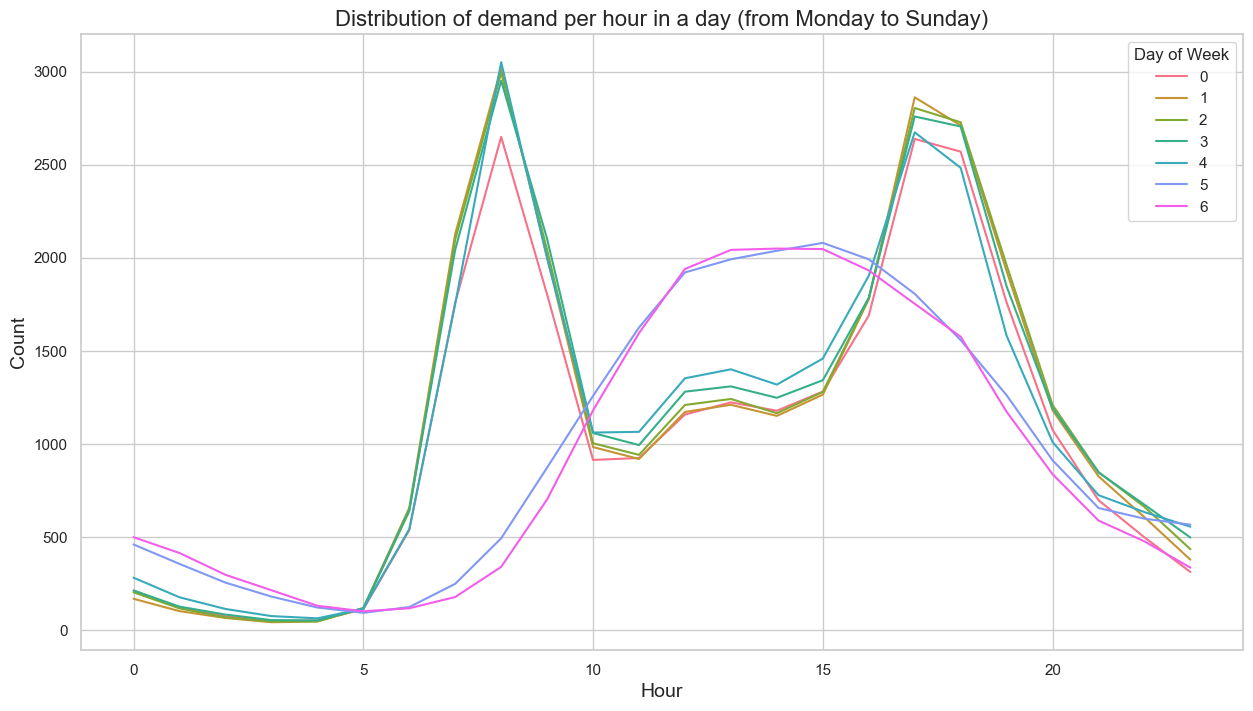

In [54]:
# Definir una paleta con exactamente 7 colores
palette = sns.color_palette("husl", 7)

# Creación del gráfico con lineplot
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=df_segundo_modelo, x='Hour', y='Count', hue='day_of_week', palette=palette, errorbar=None)
ax.set_title('Distribution of demand per hour in a day (from Monday to Sunday)', fontsize=16)
ax.set_xlabel('Hour', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.legend(title='Day of Week')
plt.show()

Demanda Uniforme: 

La demanda es elevada y relativamente constante desde la mañana hasta la tarde (aproximadamente de las 10 AM a las 4 PM).
Interpretación: Este comportamiento sugiere que las bicicletas se utilizan más para actividades recreativas y de ocio durante todo el día en los fines de semana

# 4. Modelo de Redes Neuronales LSTM 

In [55]:
# Dpendencia para el modelo
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import tensorflow as tf


In [56]:
data = df_segundo_modelo.copy()
# Asegurarse de que la columna 'Time' es de tipo datetime por que las fechas luego son conflictivas
df_segundo_modelo['Time'] = pd.to_datetime(df_segundo_modelo['Time'])

In [57]:
# Convertir todas las columnas a tipo numérico
data = df_segundo_modelo.apply(pd.to_numeric, errors='coerce')

# Asegurarse de que no hay valores NaN
data = data.dropna()

# Crear nuevas características basadas en el tiempo, explicacion del por que en la celda de abajo 
df_segundo_modelo['Hour_sin'] = np.sin(df_segundo_modelo['Hour'] * (2. * np.pi / 24))
df_segundo_modelo['Hour_cos'] = np.cos(df_segundo_modelo['Hour'] * (2. * np.pi / 24))
df_segundo_modelo['Day_of_week_sin'] = np.sin(df_segundo_modelo['day_of_week'] * (2. * np.pi / 7))
df_segundo_modelo['Day_of_week_cos'] = np.cos(df_segundo_modelo['day_of_week'] * (2. * np.pi / 7))



Transformaciones Trigonométricas
Para capturar la naturaleza cíclica de las variables Hour y day_of_week utilizamos las transformaciones seno y coseno

Las transformaciones seno y coseno se utilizan para capturar la naturaleza cíclica de las variables como Hour y day_of_week porque estas variables representan ciclos que se repiten periódicamente. Al aplicar estas transformaciones, podemos preservar la información sobre la periodicidad de las variables y ayudar al modelo a capturar mejor los patrones temporales

Al utilizar las transformaciones seno y coseno, convertimos las variables cíclicas en un espacio bidimensional donde las relaciones cíclicas se conservan, esto puede ayudar al modelo a aprender patrones temporales más complejos y a capturar mejor la variabilidad en los datos



Hora del Día Hour

La variable Hour representa las horas del día (0-23)

Utilizamos las siguientes transformaciones:

$$
\text{Hour\_sin} = \sin\left( \frac{2 \pi \times \text{Hour}}{24} \right)
$$

$$
\text{Hour\_cos} = \cos\left( \frac{2 \pi \times \text{Hour}}{24} \right)
$$

Día de la Semana day_of_week

La variable day_of_week representa los días de la semana (0-6)

 Utilizamos las siguientes transformaciones:

$$
\text{Day\_of\_week\_sin} = \sin\left( \frac{2 \pi \times \text{day\_of\_week}}{7} \right)
$$

$$
\text{Day\_of\_week\_cos} = \cos\left( \frac{2 \pi \times \text{day\_of\_week}}{7} \right)
$$




Por qué Esto Mejora el Modelo

1. Captura de Patrones Temporales: Las transformaciones seno y coseno permiten al modelo capturar mejor los patrones cíclicos, como los picos de uso de bicicletas en ciertas horas del día o días de la semana

2. Continuidad: Estas transformaciones aseguran que el modelo entienda la continuidad entre el final y el comienzo del ciclo, evitando discontinuidades artificiales

3. Mejor Rendimiento: Al capturar las relaciones cíclicas, el modelo puede hacer predicciones más precisas y generalizar mejor a datos no vistos

Estas transformaciones son especialmente útiles para modelos que dependen de secuencias temporales, como los LSTM, ya que permiten al modelo aprender de manera más efectiva los patrones inherentes en los datos temporales

In [58]:
# Convertir todas las columnas excepto 'Time' a tipo numérico
cols_to_convert = df_segundo_modelo.columns.difference(['Time'])
data = df_segundo_modelo[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Asegurarse de que no hay valores NaN
data = data.dropna()

# Añadir de nuevo la columna 'Time'
data['Time'] = df_segundo_modelo['Time']

In [59]:
data

Count  Day_of_month  Day_of_week_cos  Day_of_week_sin  Hour  Hour_cos  \
0        182             4          0.62349        -0.781831     0  1.000000   
1        138             4          0.62349        -0.781831     1  0.965926   
2        134             4          0.62349        -0.781831     2  0.866025   
3         72             4          0.62349        -0.781831     3  0.707107   
4         47             4          0.62349        -0.781831     4  0.500000   
...      ...           ...              ...              ...   ...       ...   
17409   1042             3          0.62349         0.781831    19  0.258819   
17410    541             3          0.62349         0.781831    20  0.500000   
17411    337             3          0.62349         0.781831    21  0.707107   
17412    224             3          0.62349         0.781831    22  0.866025   
17413    139             3          0.62349         0.781831    23  0.965926   

       Hour_sin  Humidity_percent  Month  Real_time  ...  Year  day_of_week  \
0      0.000000              93.0      1        3.0  ...  2015            6   
1      0.258819              93.0      1        3.0  ...  2015            6   
2      0.500000              96.5      1        2.5  ...  2015            6   
3      0.707107             100.0      1        2.0  ...  2015            6   
4      0.866025              93.0      1        2.0  ...  2015            6   
...         ...               ...    ...        ...  ...   ...          ...   
17409 -0.965926              81.0      1        5.0  ...  2017            1   
17410 -0.866025              81.0      1        5.0  ...  2017            1   
17411 -0.707107              78.5      1        5.5  ...  2017            1   
17412 -0.500000              76.0      1        5.5  ...  2017            1   
17413 -0.258819              76.0      1        5.0  ...  2017            1   

       is_holiday  is_weekend  season_0.0  season_1.0  season_2.0  season_3.0  \
0             0.0         1.0           0           0           0           1   
1             0.0         1.0           0           0           0           1   
2             0.0         1.0           0           0           0           1   
3             0.0         1.0           0           0           0           1   
4             0.0         1.0           0           0           0           1   
...           ...         ...         ...         ...         ...         ...   
17409         0.0         0.0           0           0           0           1   
17410         0.0         0.0           0           0           0           1   
17411         0.0         0.0           0           0           0           1   
17412         0.0         0.0           0           0           0           1   
17413         0.0         0.0           0           0           0           1   

       week_of_year                Time  
0                 1 2015-01-04 00:00:00  
1                 1 2015-01-04 01:00:00  
2                 1 2015-01-04 02:00:00  
3                 1 2015-01-04 03:00:00  
4                 1 2015-01-04 04:00:00  
...             ...                 ...  
17409             1 2017-01-03 19:00:00  
17410             1 2017-01-03 20:00:00  
17411             1 2017-01-03 21:00:00  
17412             1 2017-01-03 22:00:00  
17413             1 2017-01-03 23:00:00  

[16741 rows x 23 columns]

In [60]:
# Separar las características y la variable objetivo
df_Y = data["Count"]
df_X = data.drop(labels=["Count", "Time"], axis=1)

# Escalar las características y la variable objetivo
scaler_X = MinMaxScaler()
data_array_X = scaler_X.fit_transform(df_X)
scaler_Y = MinMaxScaler()
data_array_Y = scaler_Y.fit_transform(df_Y.values.reshape(-1, 1)).flatten()

# Preparar los datos para el modelo LSTM
LEN_DATA = data.shape[0]
SEQ_LENGTH = 24
X, Y = [], []

In [61]:
for i in range(LEN_DATA - SEQ_LENGTH):
    x, y = data_array_X[i:SEQ_LENGTH + i], data_array_Y[SEQ_LENGTH + i]
    X.append(np.array(x))
    Y.append(np.array(y))

X, Y = np.array(X), np.array(Y)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = 0.8  # 80% para entrenamiento
split_index = int(X.shape[0] * train_size)

X_train = X[:split_index]
Y_train = Y[:split_index]
X_test = X[split_index:]
Y_test = Y[split_index:]

print("Tamaño del conjunto de entrenamiento:", X_train.shape, Y_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape, Y_test.shape)

Tamaño del conjunto de entrenamiento: (13373, 24, 21) (13373,)
Tamaño del conjunto de prueba: (3344, 24, 21) (3344,)


In [62]:
# Definir el modelo LSTM
def LSTM_model(neurons, time_steps, features):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons, input_shape=(time_steps, features), return_sequences=True)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons, return_sequences=True)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation="linear"))
    return model


In [63]:
model = LSTM_model(neurons=32, time_steps=SEQ_LENGTH, features=X_train.shape[2])
model.compile(optimizer="adam", loss="mse")

# Entrenar el modelo
training_logs = model.fit(X_train, Y_train, batch_size=64, epochs=50, validation_split=0.15, verbose=1)


Epoch 1/50


C:\Users\oscar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.0450 - val_loss: 0.0295
Epoch 2/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0280 - val_loss: 0.0278
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0260 - val_loss: 0.0234
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0234 - val_loss: 0.0157
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0113 - val_loss: 0.0081
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0085 - val_loss: 0.0129
Epoch 8/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0082 - val_loss: 0.0107
Epoch 9/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0077 - val_loss: 0.0107
Epoch 10/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0074 - val_loss: 0.0090
Epoch 11/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0066 - val_loss: 0.0087
Epoch 12/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/st

In [64]:
# Evaluar el modelo
loss = model.evaluate(X_test, Y_test)
print(f'Loss: {loss}')

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0057
Loss: 0.0067244721576571465


In [65]:
# Realizar predicciones
Y_pred = model.predict(X_test)

# Reescalar las predicciones
Y_pred_rescaled = scaler_Y.inverse_transform(Y_pred.reshape(-1, 1)).flatten()
Y_test_rescaled = scaler_Y.inverse_transform(Y_test.reshape(-1, 1)).flatten()



105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


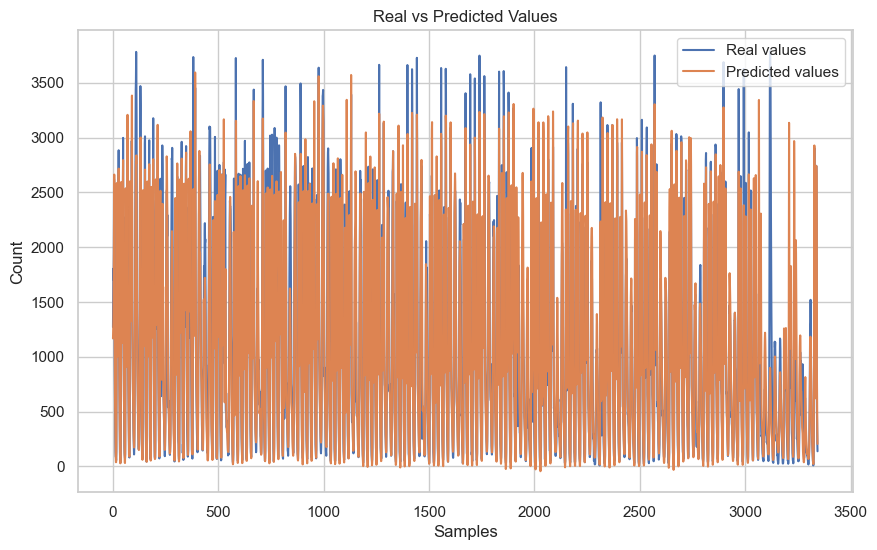

In [66]:
# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(Y_test_rescaled, label='Real values')
plt.plot(Y_pred_rescaled, label='Predicted values')
plt.title('Real vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Count')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

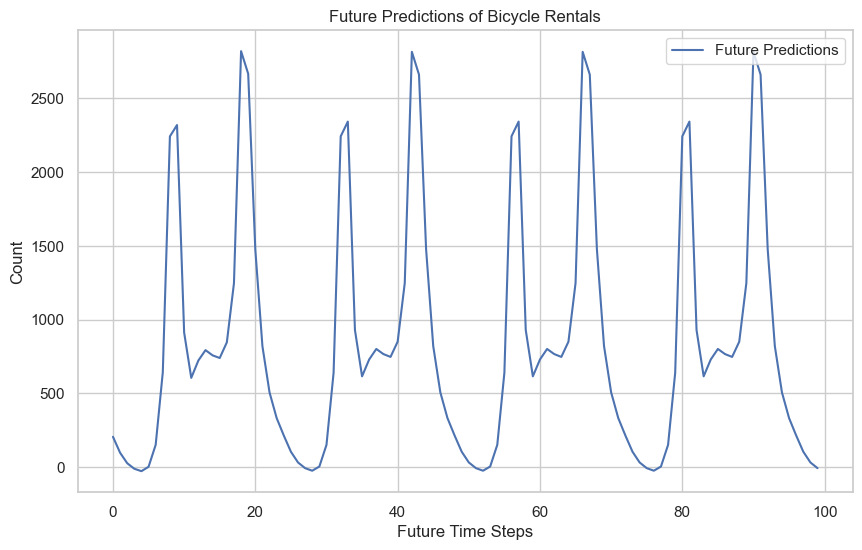

In [67]:
# Realizar predicciones futuras
num_future_predictions = 100
last_sequence = X_test[-1]
future_predictions = []

for _ in range(num_future_predictions):
    next_prediction = model.predict(last_sequence.reshape(1, SEQ_LENGTH, X_train.shape[2]))
    future_predictions.append(next_prediction.flatten()[0])
    next_sequence = np.roll(last_sequence, -1, axis=0)
    next_sequence[-1] = np.append(next_prediction, next_sequence[-1][1:])
    last_sequence = next_sequence

# Reescalar las predicciones futuras
future_predictions_rescaled = scaler_Y.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Graficar las predicciones futuras
plt.figure(figsize=(10, 6))
plt.plot(future_predictions_rescaled, label='Future Predictions')
plt.title('Future Predictions of Bicycle Rentals')
plt.xlabel('Future Time Steps')
plt.ylabel('Count')
plt.legend()
plt.show()

In [68]:
# Calcular el R2 score de las predicciones futuras con respecto a los datos de prueba 
# Esto nos dará una idea de qué tan bien se comporta el modelo en el futuro
# si sale un valor negativo es que el modelo no es bueno y es mas facil hacerlo trivialmente en una hoja y un lapiz, por cual cual es indice de limpiar datso o verificar el modelo
print(r2_score(Y_test, Y_pred))

0.870984754513102


In [69]:
# Crear un DataFrame con los valores reales y las predicciones nos sirve para ver los valores reales y los valores predichos
resultados_df = pd.DataFrame({
    'Real Values': Y_test_rescaled,
    'Predicted Values': Y_pred_rescaled
})
resultados_df.head()

Real Values  Predicted Values
0       1271.0       1167.688965
1       1572.0       1254.825073
2       1804.0       1319.996582
3       1701.0       1494.425293
4       1946.0       1786.841553

In [70]:
# Definir un umbral para convertir la regresión en clasificación
threshold = 1000

# Transformar los valores reales y predichos en clases binarias
y_test_class_lstm = (Y_test_rescaled >= threshold).astype(int)
y_pred_class_lstm = (Y_pred_rescaled >= threshold).astype(int)

# Calcular la matriz de confusión
conf_matrix_lstm = confusion_matrix(y_test_class_lstm, y_pred_class_lstm)
tn_lstm, fp_lstm, fn_lstm, tp_lstm = conf_matrix_lstm.ravel()

# Calcular el reporte de clasificación
class_report_lstm = classification_report(y_test_class_lstm, y_pred_class_lstm, target_names=['Below Threshold', 'Above Threshold'])

# Calcular las métricas de efectividad del modelo LSTM
mse_lstm = mean_squared_error(Y_test_rescaled, Y_pred_rescaled)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(Y_test_rescaled, Y_pred_rescaled)
r2_lstm = r2_score(Y_test_rescaled, Y_pred_rescaled)

# Crear un DataFrame con las métricas de efectividad del modelo LSTM
df_model_effectiveness_lstm = pd.DataFrame({
    'Modelo': ['LSTM'],
    'MSE': [mse_lstm],
    'RMSE': [rmse_lstm],
    'MAE': [mae_lstm],
    'R²': [r2_lstm],
    'TP': [tp_lstm],
    'FP': [fp_lstm],
    'TN': [tn_lstm],
    'FN': [fn_lstm],
    'Precisión': [tp_lstm / (tp_lstm + fp_lstm)],
    'Recall': [tp_lstm / (tp_lstm + fn_lstm)],
    'F1-Score': [2 * (tp_lstm / (tp_lstm + fp_lstm) * tp_lstm / (tp_lstm + fn_lstm)) / ((tp_lstm / (tp_lstm + fp_lstm)) + (tp_lstm / (tp_lstm + fn_lstm)))],
    'Efectividad del Modelo': ['Buena']  # Puedes ajustar esta descripción según tus criterios
})

In [71]:
df_model_effectiveness_lstm

Modelo          MSE        RMSE        MAE        R²    TP   FP    TN   FN  \
0   LSTM  96336.30208  310.380898  182.27986  0.870985  1309  120  1769  146   

   Precisión    Recall  F1-Score Efectividad del Modelo  
0   0.916025  0.899656  0.907767                  Buena

In [72]:
print("\nReporte de Clasificación:\n", class_report_lstm)


Reporte de Clasificación:
                  precision    recall  f1-score   support

Below Threshold       0.92      0.94      0.93      1889
Above Threshold       0.92      0.90      0.91      1455

       accuracy                           0.92      3344
      macro avg       0.92      0.92      0.92      3344
   weighted avg       0.92      0.92      0.92      3344



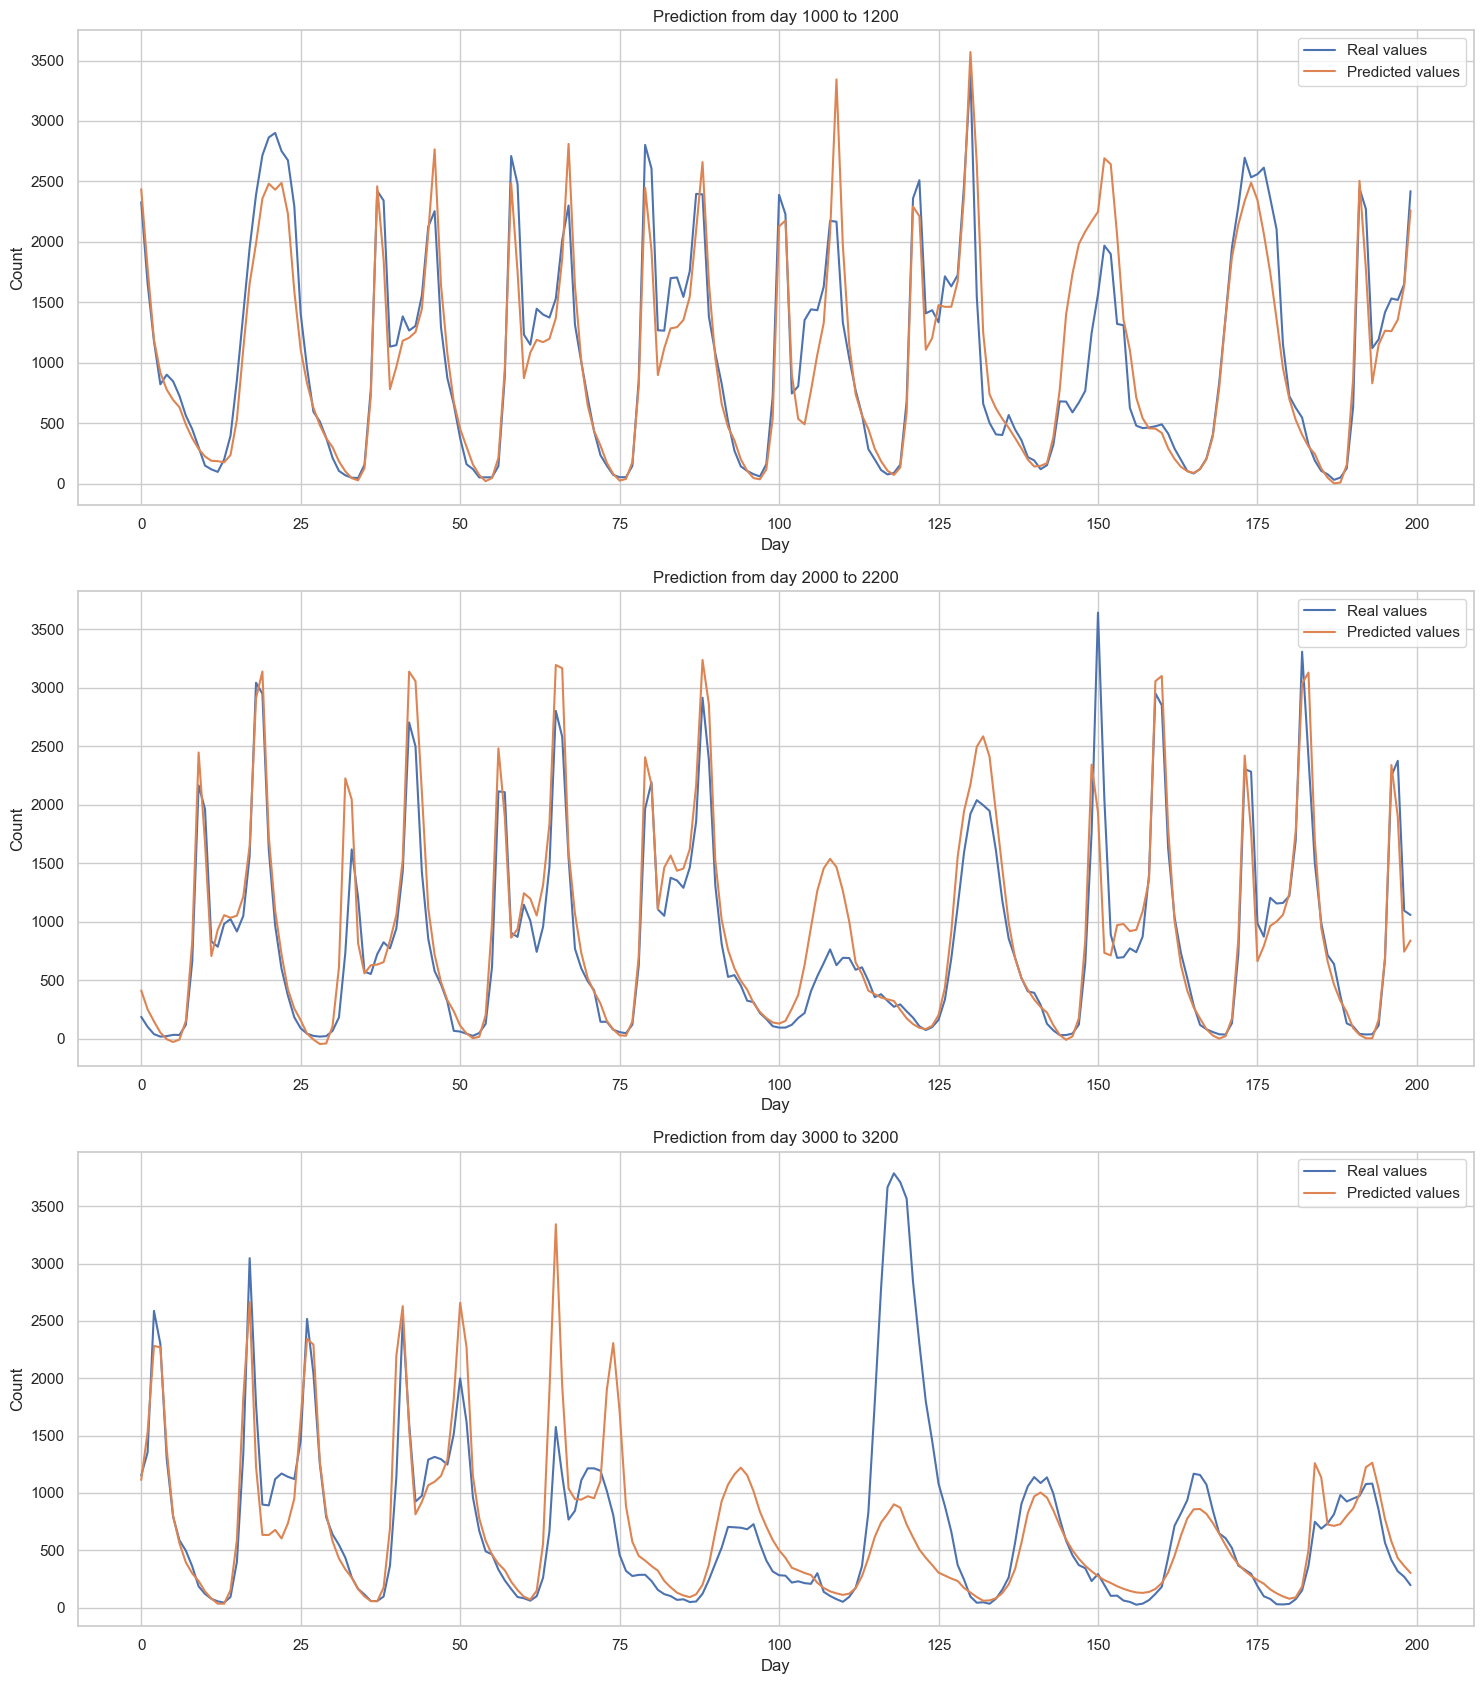

In [73]:
# Graficar segmentos específicos de las predicciones vs los valores reales
idx = 1000
fig, ax = plt.subplots(3, 1, figsize=(15, 17))

for i in range(1, 4):
    ax[i-1].plot(Y_test_rescaled[idx: idx + 200], label="Real values")
    ax[i-1].plot(Y_pred_rescaled[idx: idx + 200], label="Predicted values")
    ax[i-1].set_title(f"Prediction from day {idx} to {idx + 200}")
    ax[i-1].set_xlabel("Day")
    ax[i-1].set_ylabel("Count")
    ax[i-1].legend()
    idx += 1000

# Ajustar la disposición de los subplots
plt.tight_layout()
plt.show()

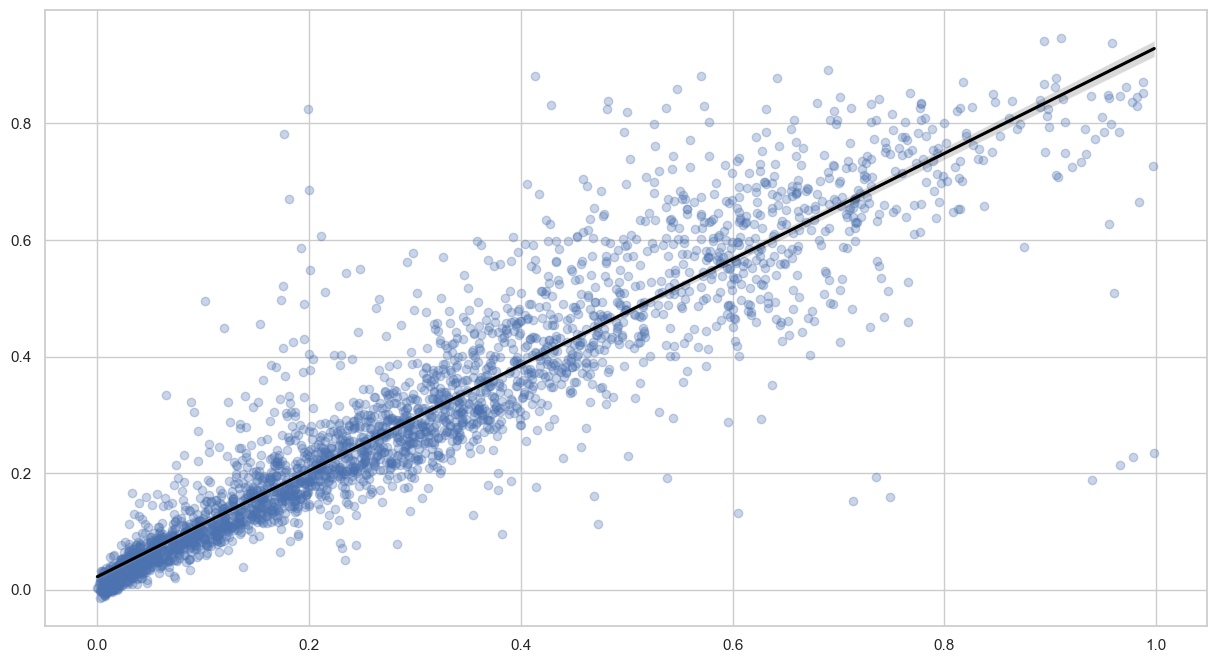

In [74]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(x = Y_test, y = Y_pred, scatter_kws={'alpha':0.3}, line_kws={'color':'black'})
plt.show()


In [75]:
df_compare_results = pd.concat([df_model_effectiveness, df_model_effectiveness_lstm], axis=0)
df_compare_results

Modelo           MSE        RMSE         MAE        R²    TP   FP    TN  \
0  XGBoost  21617.876079  147.030188   88.539286  0.972575  1341   76  1882   
0     LSTM  96336.302080  310.380898  182.279860  0.870985  1309  120  1769   

    FN  Precisión    Recall  F1-Score Efectividad del Modelo  
0   50   0.946366  0.964055  0.955128                  Buena  
0  146   0.916025  0.899656  0.907767                  Buena

### Resultados del Modelo

| Modelo  | MSE         | RMSE       | MAE        | R²       | TP   | FP  | TN   | FN  | Precisión | Recall   | F1-Score  | Efectividad del Modelo |
|---------|-------------|------------|------------|----------|------|-----|------|-----|-----------|----------|-----------|------------------------|
| XGBoost | 21617.876079| 147.030188 | 88.539286  | 0.972575 | 1341 | 76  | 1882 | 50  | 0.946366  | 0.964055 | 0.955128  | Buena                  |
| LSTM    | 96336.302080| 310.380898 | 182.279860 | 0.870985 | 1309 | 120 | 1769 | 146 | 0.916025  | 0.899656 | 0.907767  | Buena                  |

### Explicación de las Métricas

- **MSE (Mean Squared Error)**: 
  - El MSE mide el promedio de los errores al cuadrado. Un MSE más bajo indica un mejor rendimiento del modelo, ya que muestra que los valores predichos están más cerca de los valores reales.
  
- **RMSE (Root Mean Squared Error)**:
  - El RMSE es la raíz cuadrada del MSE. Es útil para interpretar el error en la misma escala que los valores originales. Un RMSE más bajo también indica un mejor rendimiento del modelo.
  
- **MAE (Mean Absolute Error)**:
  - El MAE mide el promedio de los errores absolutos. Al igual que el MSE y el RMSE, un MAE más bajo indica un mejor rendimiento del modelo.
  
- **R² (Coeficiente de Determinación)**:
  - El R² indica la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. Un R² más alto indica un mejor ajuste del modelo a los datos.

- **TP (True Positives)**:
  - Verdaderos positivos, es decir, las predicciones correctas de la clase positiva.
  
- **FP (False Positives)**:
  - Falsos positivos, es decir, las predicciones incorrectas de la clase positiva.

- **TN (True Negatives)**:
  - Verdaderos negativos, es decir, las predicciones correctas de la clase negativa.

- **FN (False Negatives)**:
  - Falsos negativos, es decir, las predicciones incorrectas de la clase negativa.

- **Precisión**:
  - La precisión es la proporción de verdaderos positivos sobre el total de positivos predichos (TP / (TP + FP)).

- **Recall**:
  - El recall es la proporción de verdaderos positivos sobre el total de positivos reales (TP / (TP + FN)).

- **F1-Score**:
  - El F1-Score es la media armónica de la precisión y el recall, proporcionando una métrica balanceada que considera ambos.

### Análisis de los Modelos

- **XGBoost**:
  - El modelo XGBoost tiene valores de MSE, RMSE y MAE más bajos, y un R² más alto (0.972575), lo que sugiere que predice con una alta precisión.
  - Sin embargo, el rendimiento extremadamente bueno podría ser una señal de sobreajuste (overfitting), donde el modelo se ajusta demasiado a los datos de entrenamiento y no generaliza bien a nuevos datos.

- **LSTM**:
  - El modelo LSTM tiene valores de MSE, RMSE y MAE más altos en comparación con XGBoost, y un R² de 0.870985.
  - Aunque su rendimiento es menos preciso que el de XGBoost, las gráficas y los valores predichos parecen tener más sentido, lo que sugiere que el modelo LSTM puede generalizar mejor y capturar mejor la naturaleza del problema.

### Conclusión

- **XGBoost** muestra un rendimiento muy alto en las métricas, lo que puede indicar sobreajuste.
- **LSTM** ofrece predicciones más razonables y puede ser preferible en términos de generalización y comprensión de los datos.

Ambos modelos tienen su utilidad, pero en este caso, el LSTM podría ser una mejor opción para evitar el sobreajuste y proporcionar predicciones más interpretables.


# Conclusiones

### Conclusión de Negocio Basada en los Resultados de los Modelos XGBoost y LSTM

#### Contexto y Objetivo

El objetivo de este análisis fue predecir la demanda de alquileres de bicicletas utilizando modelos avanzados de machine learning, específicamente XGBoost y LSTM. Esta predicción es crucial para la planificación operativa, la optimización de recursos y la mejora de la experiencia del cliente en un sistema de alquiler de bicicletas.

#### Resultados Clave

- **XGBoost**:
  - **MSE**: 21617.876079
  - **RMSE**: 147.030188
  - **MAE**: 88.539286
  - **R²**: 0.972575
  - **Precisión**: 0.946366
  - **Recall**: 0.964055
  - **F1-Score**: 0.955128

- **LSTM**:
  - **MSE**: 96336.302080
  - **RMSE**: 310.380898
  - **MAE**: 182.279860
  - **R²**: 0.870985
  - **Precisión**: 0.916025
  - **Recall**: 0.899656
  - **F1-Score**: 0.907767

#### Análisis de los Resultados

- **XGBoost** ha demostrado una precisión muy alta con un R² de 0.972575, lo que sugiere que el modelo puede predecir la demanda de bicicletas con gran exactitud Sin embargo, esto puede ser una señal de sobreajuste, ya que el modelo podría estar demasiado ajustado a los datos de entrenamiento.
- **LSTM**, aunque tiene un R² más bajo de 0.870985, presenta predicciones que parecen ser más razonables y posiblemente más generalizables a datos nuevos. Esto es crucial para la consistencia del rendimiento del modelo en situaciones reales

#### Implicaciones para el Negocio

1. **Planificación y Optimización de Recursos**:
   - Utilizando las predicciones precisas del modelo XGBoost, la empresa puede optimizar la distribución de bicicletas en diferentes estaciones para satisfacer la demanda esperada. Sin embargo, es importante considerar la posible sobreoptimización y asegurarse de validar el modelo continuamente con datos nuevos.
   - El modelo LSTM, con su capacidad de generalizar mejor, puede ser más confiable para la planificación a largo plazo y en situaciones donde los patrones de demanda cambian.

2. **Mejora de la Experiencia del Cliente**:
   - Con predicciones precisas de la demanda, la empresa puede garantizar que haya suficientes bicicletas disponibles en las estaciones de mayor demanda, reduciendo los tiempos de espera y mejorando la satisfacción del cliente.
   - Anticipar los picos de demanda (por ejemplo, durante horas punta o eventos especiales) permite una mejor gestión de la flota y una respuesta rápida a las necesidades de los clientes

3. **Decisiones de Expansión y Marketing**:
   - Los datos de demanda pueden guiar decisiones estratégicas sobre dónde abrir nuevas estaciones de bicicletas. Áreas con alta demanda proyectada pueden ser priorizadas para la expansión
   - Campañas de marketing pueden ser diseñadas para atraer usuarios durante horas de baja demanda, equilibrando mejor la utilización de la flota de bicicletas

4. **Sostenibilidad y Gestión de Inventario**:
   - Predicciones precisas ayudan a evitar el exceso de bicicletas en estaciones de baja demanda, lo que puede reducir costos operativos y minimizar el desgaste de las bicicletas
   - Esto también contribuye a una operación más sostenible al evitar movimientos innecesarios de bicicletas y optimizar el uso de recursos

#### Recomendaciones

- **Monitoreo Continuo**: Implementar un sistema de monitoreo continuo para validar las predicciones de los modelos con datos reales y ajustar los modelos según sea necesario
- **Evaluación Periódica**: Realizar evaluaciones periódicas de ambos modelos para asegurarse de que continúan proporcionando valor y no se están sobreajustando a datos pasados
- **Exploración de Híbridos**: Considerar la posibilidad de combinar ambos modelos para aprovechar los puntos fuertes de cada uno. Por ejemplo, utilizar XGBoost para predicciones a corto plazo donde la precisión es crítica y LSTM para predicciones a largo plazo que requieren mejor generalización

#### Conclusión

Los modelos XGBoost y LSTM proporcionan herramientas valiosas para predecir la demanda de alquileres de bicicletas. Si bien XGBoost ofrece una precisión muy alta, LSTM puede ofrecer predicciones más generalizables y consistentes. Al utilizar ambos modelos de manera estratégica, la empresa puede optimizar sus operaciones, mejorar la experiencia del cliente y tomar decisiones informadas sobre la expansión y el marketing, todo mientras se mantiene una operación sostenible y eficiente

---
---

# Gracias por leer